# First data exploration
in this file I'm going to explore the data. By doing:
- Define your labels/response in a categorical manner (high response, low response, late response,..) based on the behaviour of the antibody titers of these individuals. This is what is usually done, or you can keep the antibodies as numbers and try and predict the numerical value.
- Not do much feature engineering and focus to first see what a couple of methodologies can predict as a starter
- Group the features based on coexpression/do a first dimensionality reduction (PCA) and group features based on the biplot of the PCA.
- You can look up what some of these features mean and maybe use your findings to guide your way of combining them but I would keep a data driven approach
- Since you still have more than one dataset you could look at different ways of combining the information, either at the start or by building separate models for each dataset
- You will have to keep in mind that:
  - you have to somehow encode multiple features into a single feature
  - deal with low number of samples also in the way you evaluate the models
  - define the feature contributions at all steps as explainability is a big component of this kind of work
  - There may be missing values to deal with

### loading all datasets

In [266]:
# Standard Library Imports
from collections import Counter

# Third-Party Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from upsetplot import from_memberships, plot
from scipy.stats import chi2_contingency, f_oneway
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# scikit-learn Imports
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Local Imports
from helper_functions.helper import model_with_shap

In [267]:
# Load the antibody titers data (response profile)
abtiters = pd.read_csv('../data/Measles/antibody_df.csv')

# Load the cytokines data
cytokines = pd.read_csv('../data/Measles/cytokines_data.csv')

# Load the cytometry data
cytometry = pd.read_csv('../data/Measles/cyto_data.csv')

In [268]:
# Display the first few rows of each dataset
print("Abutters (antibody titers) dataset:")
print(abtiters.head())

print("\nCytokines dataset:")
print(cytokines.head())

print("\ncytometry dataset:")
print(cytometry.head())

Abutters (antibody titers) dataset:
        vaccine Vaccinee  Day 0  Day 21  Day 150  Day 365  diff: 21-0  \
0  Anti-Measles       M1    5.0   217.0     30.8     31.5       212.0   
1  Anti-Measles      M11   17.9    30.1    300.0    214.0        12.2   
2  Anti-Measles      M12  300.0   300.0    300.0    300.0         0.0   
3  Anti-Measles      M13  227.0   300.0    236.0    300.0        73.0   
4  Anti-Measles      M14   26.7   261.0    276.0    300.0       234.3   

   diff: 150-21  diff: 365-150  response  protected               quadrant  
0        -186.2            0.7      True       True              responder  
1         269.9          -86.0     False      False   no response - low ab  
2           0.0            0.0     False       True  no response - high ab  
3         -64.0           64.0     False       True  no response - high ab  
4          15.0           24.0      True       True              responder  

Cytokines dataset:
  Vaccinee  CMV.Status  EBV.Status  HSV1_2.

###### Antibody Titers Dataset:
| Column Name | Description |
| --- | --- | 
| vaccine | The type of vaccine administered to the individual (e.g., Anti-Measles). |
| Vaccinee | The identifier for the individual receiving the vaccine (e.g., M1, M11). |
| Day 0 | The measured antibody titer on Day 0, which is typically the baseline measurement before vaccination. |
| Day 21 | The measured antibody titer on Day 21, indicating the antibody response after vaccination. (could be an important signal for how well the individual responded to the vaccine.) |


###### Cytokines Dataset:
| Column Name | Description |
| --- | --- | 
| Vaccinee | Identifier for the individual (should match with the Vaccinee field in the Antibody Titers dataset). |
| CMV.Status | Cytomegalovirus infection status (binary: 1 = positive, 0 = negative). |
| EBV.Status | Epstein-Barr Virus infection status (binary: 1 = positive, 0 = negative). |
| HSV1_2.Status	| Herpes Simplex Virus (types 1 and 2) infection status (binary). |
| HHV6.Status | Human Herpesvirus 6 infection status (binary). |
| EGF | Measured concentration of Epidermal Growth Factor (EGF) in the blood. |
| FGF-2	| Fibroblast Growth Factor-2 concentration. |
| Eotaxin | A cytokine responsible for eosinophil recruitment. |
| TGF-a | Transforming Growth Factor-alpha concentration. |
| GCSF | Granulocyte Colony-Stimulating Factor concentration, which promotes the growth of white blood cells. |
| ... | .	Other columns represent various cytokines and their concentrations, including inflammatory and immune response markers like IL-6, TNFa, VEGF, etc. |

###### cytometry Dataset:
| Column Name | Description |
|-------------| --- | 
| Vaccinee    |	Identifier for the individual (should match with the Vaccinee field in the Antibody Titers dataset).|
| WBC         |	White Blood Cells count, important for the immune system's ability to fight infections.|
| RBC	        | Red Blood Cells count, responsible for carrying oxygen throughout the body.|
| HGB	        | Hemoglobin level, the protein in RBCs that carries oxygen to tissues.|
| HCT	        | Hematocrit, the percentage of blood composed of red blood cells.|
| PLT	        | Platelets count, crucial for blood clotting and preventing excessive bleeding.|
| %LYM        |	Percentage of lymphocytes in total WBC, important in the adaptive immune response.|
| %MON        |	Percentage of monocytes in total WBC, involved in removing dead cells and fighting certain infections.|
| %GRA        |	Percentage of granulocytes in total WBC, essential for fighting bacterial infections and inflammation.|

In [269]:
# Check for missing values and data types
print("\nAbutters missing values and data types:")
print(abtiters.info())

print("\nCytokines missing values and data types:")
print(cytokines.info())

print("\ncytometry missing values and data types:")
print(cytometry.info()) # there are some missing values


Abutters missing values and data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   vaccine        40 non-null     object 
 1   Vaccinee       40 non-null     object 
 2   Day 0          40 non-null     float64
 3   Day 21         40 non-null     float64
 4   Day 150        40 non-null     float64
 5   Day 365        39 non-null     float64
 6   diff: 21-0     40 non-null     float64
 7   diff: 150-21   40 non-null     float64
 8   diff: 365-150  39 non-null     float64
 9   response       40 non-null     bool   
 10  protected      40 non-null     bool   
 11  quadrant       40 non-null     object 
dtypes: bool(2), float64(7), object(3)
memory usage: 3.3+ KB
None

Cytokines missing values and data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 41 columns):
 #   Column         Non-Null 

### playing around with the data

##### 1 - Decide on target labels


Frequency of responses:
response_label
no response    29
response       11
Name: count, dtype: int64


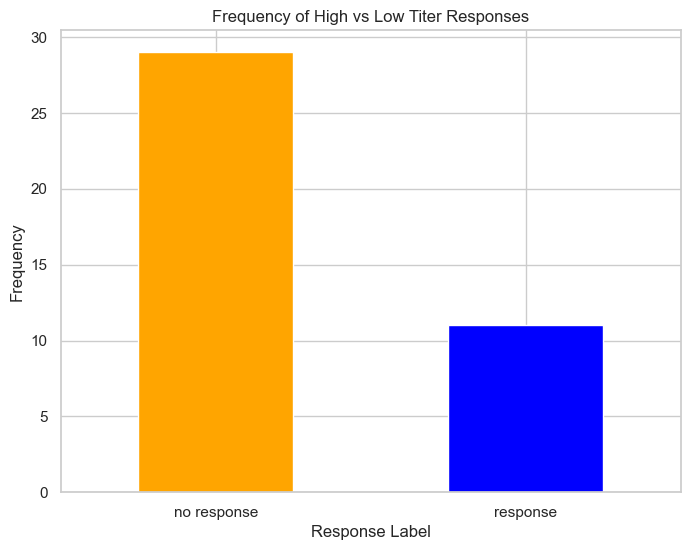

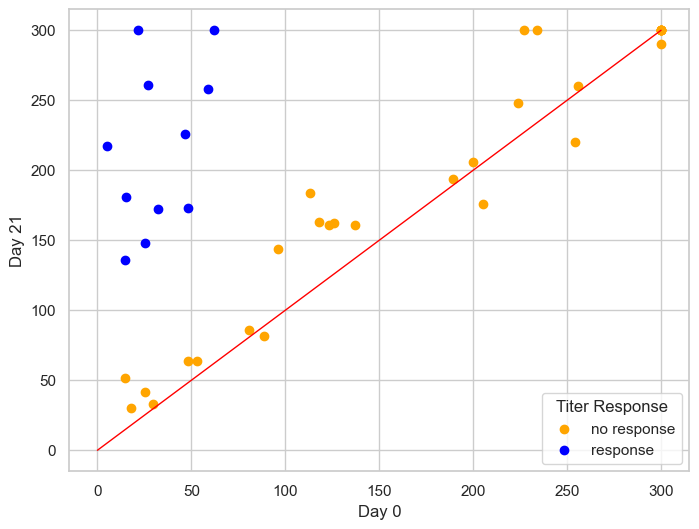

In [270]:
# Count the frequency of each label
abtiters['response_label'] = abtiters['quadrant'].apply(lambda x: 'response' if x == 'responder' else 'no response')

# Count the frequency of each label
response_counts = abtiters['response_label'].value_counts()

print("\nFrequency of responses:")
print(response_counts)

# Plot the frequency of high vs. low responses as a bar plot
plt.figure(figsize=(8, 6))
response_counts.plot(kind='bar', color=['orange', 'blue'])
plt.title('Frequency of High vs Low Titer Responses')
plt.xlabel('Response Label')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

colors = {'response': 'blue', 'no response': 'orange'}
plt.figure(figsize=(8, 6))
for label, group in abtiters.groupby('response_label'):
    plt.scatter(group['Day 0'], group['Day 21'], color=colors[label], label=label)

# Plot reference line y = x
plt.plot([0, max(abtiters['Day 0'])], [0, max(abtiters['Day 21'])], color='red', linestyle='-', linewidth=1)

# Labeling and legend
plt.xlabel('Day 0')
plt.ylabel('Day 21')
plt.legend(title="Titer Response")
plt.show()

/var/folders/gb/zs4jw5c93r55ty8g5d7wkdpm0000gn/T/ipykernel_22830/3694377312.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')


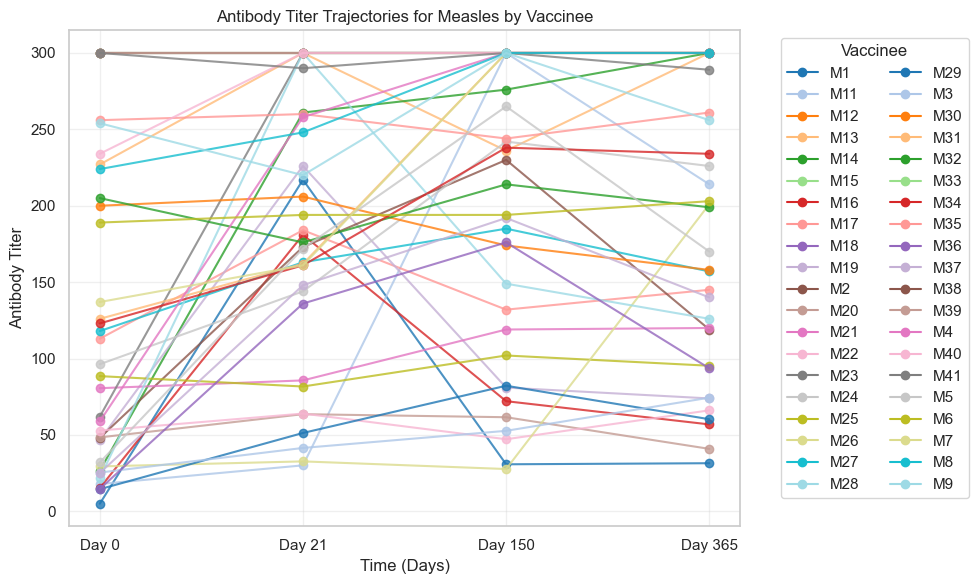

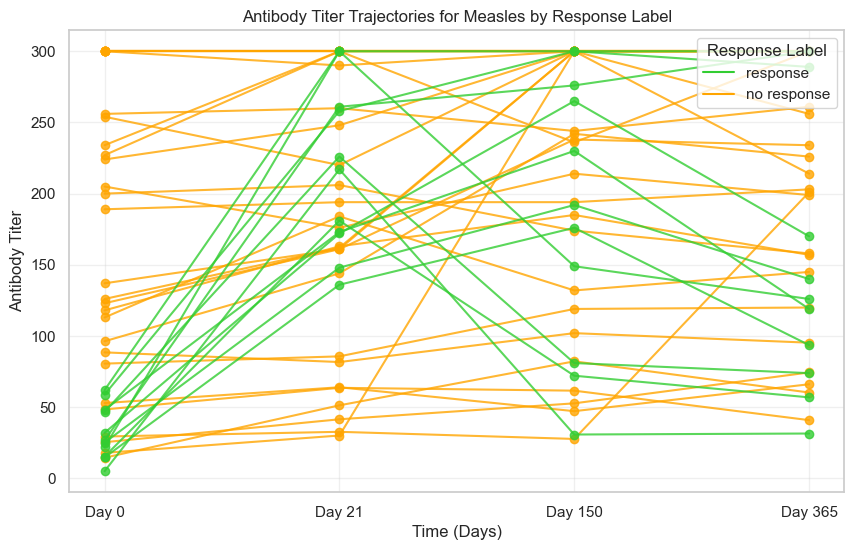

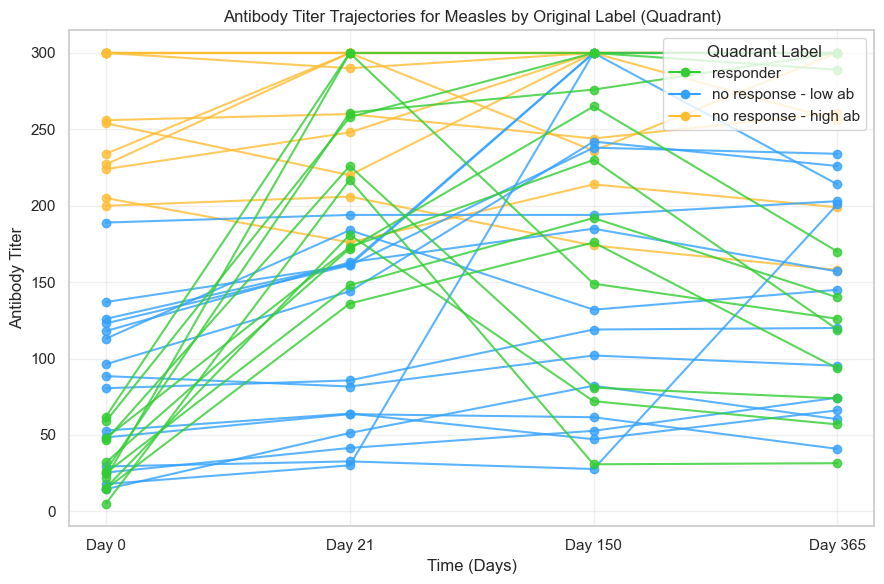

In [271]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Plot colored by "Vaccinee"
# Define mapping for time points (evenly spaced)
time_mapping = {
    'Day 0': 0,
    'Day 21': 1,
    'Day 150': 2,
    'Day 365': 3
}
x_ticks = [0, 1, 2, 3]
x_labels = ["Day 0", "Day 21", "Day 150", "Day 365"]

# Create a colormap for vaccinees, using 'tab20'
cmap = plt.cm.get_cmap('tab20')

plt.figure(figsize=(10, 6))

# Group by "Vaccinee"
vaccinees = abtiters['Vaccinee'].unique()
for i, (vac_name, group_df) in enumerate(abtiters.groupby('Vaccinee')):
    # Assign a unique color to each vaccinee from the colormap
    color = cmap(i % 20)  # cycles through if more than 20 vaccinees
    for idx, row in group_df.iterrows():
        y_values = [
            row['Day 0'],
            row['Day 21'],
            row['Day 150'],
            row['Day 365']
        ]
        x_values = [time_mapping['Day 0'], 
                    time_mapping['Day 21'], 
                    time_mapping['Day 150'], 
                    time_mapping['Day 365']]
        plt.plot(x_values, y_values, marker='o', linestyle='-', color=color, alpha=0.8)

# Create dummy handles for legend entries
dummy_handles = []
for i, vac_name in enumerate(vaccinees):
    color = cmap(i % 20)
    # Create a dummy line with the specified color
    dummy_handle, = plt.plot([], [], color=color, marker='o', linestyle='-', label=vac_name)
    dummy_handles.append(dummy_handle)

# Place the legend to the right of the plot in 2 columns
plt.legend(handles=dummy_handles, title="Vaccinee", bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

plt.title("Antibody Titer Trajectories for Measles by Vaccinee")
plt.xlabel("Time (Days)")
plt.ylabel("Antibody Titer")
plt.xticks(x_ticks, x_labels)
plt.grid(True, alpha=0.3)
plt.tight_layout()  # Adjust layout to accommodate the legend
plt.show()

# 2) Plot colored by "response_label"

# Define color dictionary for response_label
label_colors = {
    'response': 'limegreen',
    'no response': 'orange'
    # add more labels if needed
}

plt.figure(figsize=(10, 6))

for label, group_df in abtiters.groupby('response_label'):
    # For each subject in this label group
    for idx, row in group_df.iterrows():
        y_values = [
            row['Day 0'],
            row['Day 21'],
            row['Day 150'],
            row['Day 365']
        ]
        x_values = [time_mapping['Day 0'], 
                    time_mapping['Day 21'], 
                    time_mapping['Day 150'], 
                    time_mapping['Day 365']]
        
        color = label_colors.get(label, 'white')
        plt.plot(x_values, y_values, marker='o',
                 linestyle='-', color=color, alpha=0.8)

# Create dummy legend handles for the response labels
for label, color in label_colors.items():
    plt.plot([], [], color=color, label=label)

plt.title("Antibody Titer Trajectories for Measles by Response Label")
plt.xlabel("Time (Days)")
plt.ylabel("Antibody Titer")
plt.xticks(x_ticks, x_labels)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', title="Response Label")
plt.show()

# Define mapping for time points (evenly spaced)
time_mapping = {
    'Day 0': 0,
    'Day 21': 1,
    'Day 150': 2,
    'Day 365': 3
}
x_ticks = [0, 1, 2, 3]
x_labels = ["Day 0", "Day 21", "Day 150", "Day 365"]

# Get unique quadrant labels
unique_quadrants = list(abtiters['quadrant'].unique())

# Initialize color dictionary:
quadrant_colors = {}

# Ensure that 'responder' is always limegreen
if 'responder' in unique_quadrants:
    quadrant_colors['responder'] = 'limegreen'

# Pre-define a list of vibrant colors for non-responder labels
vibrant_colors = ['#33A1FF', '#FFBD33']

# For all other labels, assign colors from the pre-defined vibrant colors list.
non_responder_labels = [q for q in unique_quadrants if q != 'responder']
for i, q in enumerate(non_responder_labels):
    # Cycle through the vibrant colors if there are more labels than colors
    quadrant_colors[q] = vibrant_colors[i % len(vibrant_colors)]

plt.figure(figsize=(9, 6))

# Plot the antibody titer trajectories grouped by the original 'quadrant' label
for q_label, group_df in abtiters.groupby('quadrant'):
    for idx, row in group_df.iterrows():
        y_values = [
            row['Day 0'],
            row['Day 21'],
            row['Day 150'],
            row['Day 365']
        ]
        x_values = [time_mapping['Day 0'],
                    time_mapping['Day 21'],
                    time_mapping['Day 150'],
                    time_mapping['Day 365']]
        plt.plot(x_values, y_values, marker='o', linestyle='-', 
                 color=quadrant_colors[q_label], alpha=0.8)

# Create dummy legend handles for each quadrant label
for q_label, color in quadrant_colors.items():
    plt.plot([], [], color=color, marker='o', linestyle='-', label=q_label)

plt.title("""Antibody Titer Trajectories for Measles by Original Label (Quadrant)""")
plt.xlabel("Time (Days)")
plt.ylabel("Antibody Titer")
plt.xticks(x_ticks, x_labels)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', title="Quadrant Label")
plt.tight_layout()
plt.show()

In [272]:
# Initialize color dictionary:
quadrant_colors = {}

# Ensure that 'responder' is always limegreen
if 'responder' in unique_quadrants:
    quadrant_colors['responder'] = 'limegreen'

# Pre-define a list of vibrant colors for non-responder labels
vibrant_colors = ['#FF5733', '#33FFCE', '#FF33F6', '#33A1FF', '#FFBD33', '#A833FF', '#33FF57']

# For all other labels, assign colors from the pre-defined vibrant colors list.
non_responder_labels = [q for q in unique_quadrants if q != 'responder']
for i, q in enumerate(non_responder_labels):
    # Cycle through the vibrant colors if there are more labels than colors
    quadrant_colors[q] = vibrant_colors[i % len(vibrant_colors)]

In [273]:
abtiters = abtiters.drop(columns=['vaccine', 'Day 0', 'Day 21', 'Day 150', 'Day 365', 'diff: 21-0', 'diff: 150-21', 'diff: 365-150', 'response', 'protected','quadrant'])
print(abtiters.head())

  Vaccinee response_label
0       M1       response
1      M11    no response
2      M12    no response
3      M13    no response
4      M14       response


### To approach feature selection and get a clearer path, here's a structured framework you can follow:

1. Preliminary Data Analysis and Cleaning
Data Inspection: Examine data distribution, missing values, and outliers.
Feature Filtering: Remove features with high missingness or very low variance, as they may not be informative.

2. Initial Feature Importance Assessment
Univariate Feature Analysis: Use simple tests (e.g., ANOVA, t-tests) to see which cytokines or other features significantly differ across response groups. This can give early insights into potential markers.
Random Forest for Baseline Importance: Run Random Forest to get a quick overview of feature importances. 

3. Iterative Feature Selection with SHAP
Refined SHAP Analysis: Focus on SHAP values to interpret the influence of top features identified in Random Forest.
Recursive Feature Elimination: Pair SHAP with recursive feature elimination (RFE) or similar methods, iteratively reducing the feature set based on importance.

4. Testing Alternative Models
Experiment with other models like XGBoost or logistic regression with L1 regularization (lasso) for additional perspectives on feature importance. XGBoost can also pair well with SHAP for interpretability and is particularly effective with high-dimensional data.

5. Cross-Vaccine Validation Preparation
If you have access to data from other vaccines, validate your model with these datasets to check for marker consistency across vaccine types. This step solidifies generalizability.
This process provides a structured way to approach feature importance analysis and potentially validates immune markers across different models and vaccines. Let me know if you'd like code examples or a more detailed look into any specific step.

#### 1 Preliminary Data Analysis and Cleaning

In [274]:
## abtiters already loaded ##
## cytokines already loaded ##
cytometry = cytometry[['Vaccinee', 'WBC Day 0','RBC Day 0','HGB Day 0','HCT Day 0','PLT Day 0','%LYM Day 0','%MON Day 0','%GRA Day 0']] # already loaded


metadata = pd.read_csv('../data/Measles/metadata.csv')

gender_mapping = {'M': 1, 'F': 0}
metadata['Gender'] = metadata['Gender'].map(gender_mapping)

In [275]:
# Combine all data into a single DataFrame for easy processing
cytokines_data = cytokines.drop(columns=['Vaccinee','CMV.Status','EBV.Status','HSV1_2.Status','HHV6.Status'])
cyto_data = cytometry.drop(columns=['Vaccinee'])

In [276]:


def preliminary_data_analysis(data):
    # Apply standard scaling (z-score normalization)
    scaler = StandardScaler()
    all_data_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    
    num_columns = 5  # Number of columns in the grid
    num_rows = (len(all_data_normalized.columns) + num_columns - 1) // num_columns
    
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 20), sharey=True)
    axes = axes.flatten()
    
    for i, column in enumerate(all_data_normalized.columns):
        sns.kdeplot(all_data_normalized[column], ax=axes[i], fill=True)
        axes[i].set_title(column)
        axes[i].set_xlabel("Standardized Value")
        axes[i].set_ylabel("Density")
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 8))
    sns.boxenplot(data=all_data_normalized, orient='h')
    plt.title("Boxen Plot of Standardized Features")
    plt.xlabel("Standardized Value")
    plt.show()

preliminary_data_analysis(cytokines_data)
preliminary_data_analysis(cyto_data)

KeyboardInterrupt: 

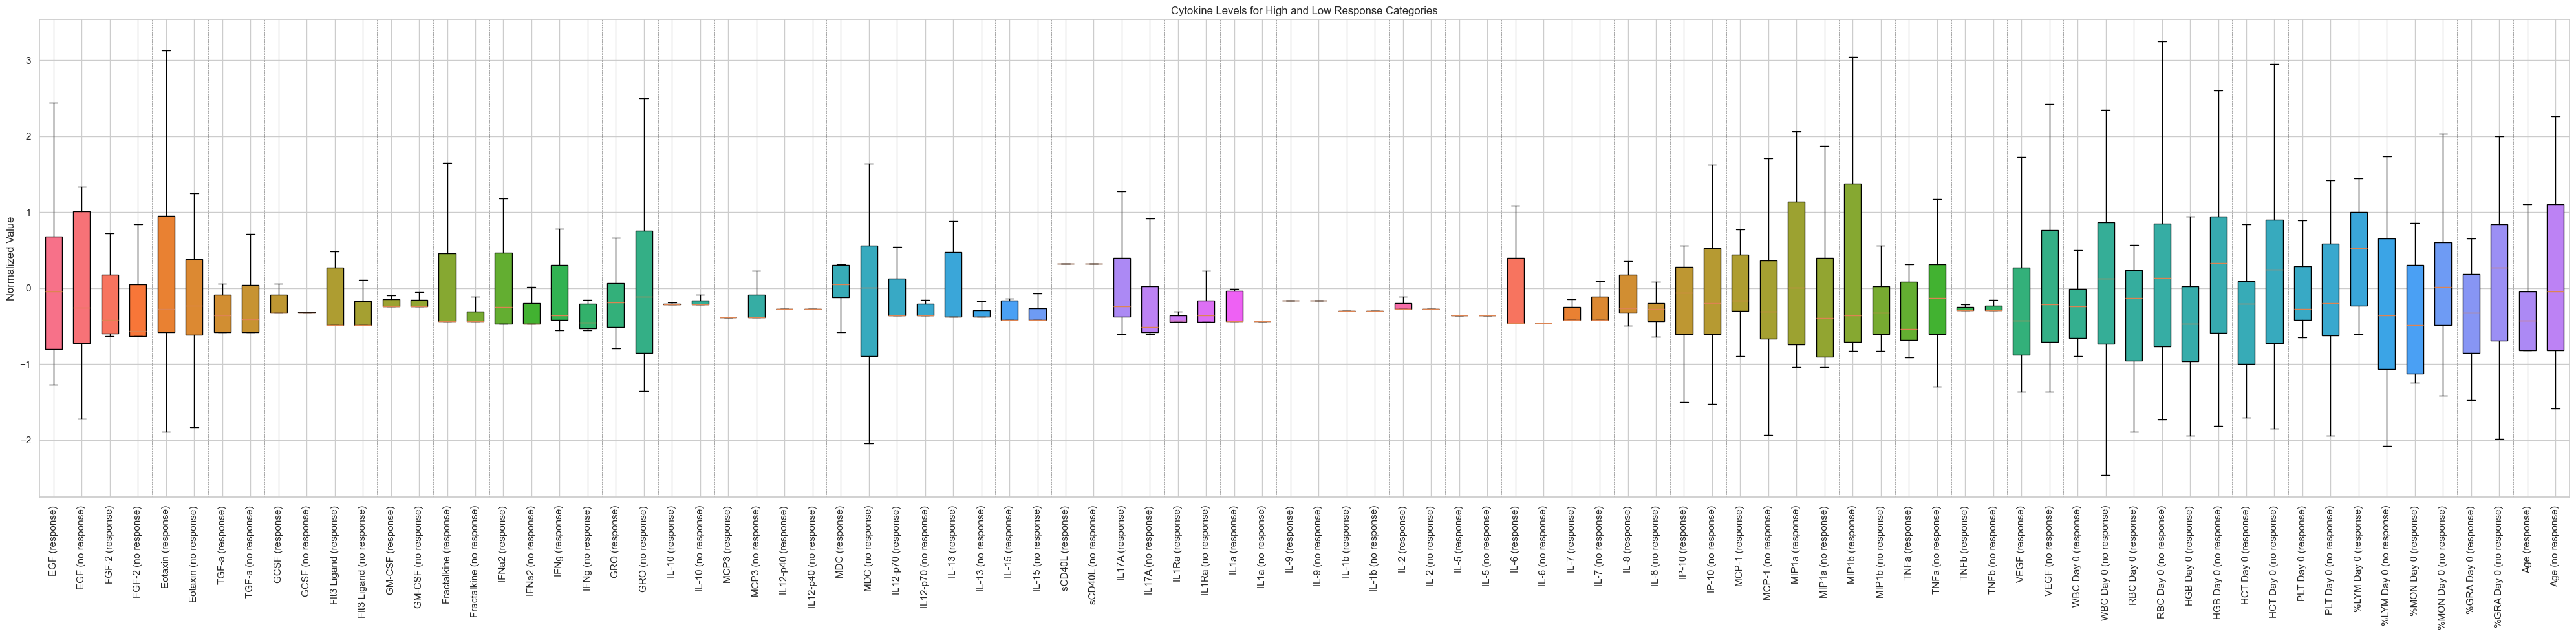

In [238]:
def distribution_of_the_data(data, labels, outliers=True):
    # Standardize the feature values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)
    X_scaled = pd.DataFrame(X_scaled, columns=data.columns)
    X_scaled['response_label'] = labels
    
    # Prepare data for side-by-side boxplots
    data_to_plot = []
    labels = []
    binary_features = []
    non_binary_features = []
    
    # Find all unique labels in response_label
    unique_labels = X_scaled['response_label'].unique()
    
    for col in data.columns:
        # Check if the column is binary (i.e., has exactly two unique values, e.g., 0 and 1)
        if data[col].nunique() == 2:
            binary_features.append(col)
        else:
            # Add data for each unique label
            for label in unique_labels:
                subset = X_scaled[X_scaled['response_label'] == label]
                data_to_plot.append(subset[col])
                labels.append(f"{col} ({label})")
            non_binary_features.append(col)
    
    # Set up color palette for alternating colors
    colors = sns.color_palette("husl", n_colors=len(data.columns))
    
    # Plot
    fig, ax = plt.subplots(figsize=(40, 10))
    box = ax.boxplot(data_to_plot, showfliers=outliers, widths=0.6, patch_artist=True)
    
    # Apply colors to each pair of boxes
    for i, (patch, color) in enumerate(zip(box['boxes'], colors * 2)):
        patch.set_facecolor(color)
    
    # Customizing data-axis
    ax.set_xticks(range(1, len(labels) + 1))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_title("Cytokine Levels for High and Low Response Categories")
    ax.set_ylabel("Normalized Value")
    
    # Adding vertical grid lines for separation
    for i in range(2, len(labels) + 1, 2):
        ax.axvline(i + 0.5, color='gray', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    
cytokines_cyto = pd.merge(cytokines, cytometry, on='Vaccinee')
merged = pd.merge(cytokines_cyto, metadata, on='Vaccinee')
merged_data = pd.merge(abtiters, merged, on='Vaccinee')

# Assuming 'merged_data' is loaded and structured with response labels and features
# Separate features and response labels
X = merged_data.drop(columns=['response_label', 'Vaccinee'])
y = merged_data['response_label']

distribution_of_the_data(X, y, outliers=False)


In [239]:
def plot_projections(X, type):
    # Map colors for responder and non-responder
    colors = {'response': 'blue', 'no response': 'orange'}
    # Plot the PCA projection with color-coded labels
    plt.figure(figsize=(10, 7))
    for label, group in X.groupby('response_label'):
        plt.scatter(group[f'{type}1'], group[f'{type}2'], color=colors[label], label=label, alpha=0.6)
    
    # Labeling and legend
    plt.title(f'{type} Projection of Immune Response Data')
    plt.xlabel(f'{type} Component 1')
    plt.ylabel(f'{type} Component 2')
    plt.legend(title="Response Label")
    plt.grid(True)
    plt.show()

In [240]:
def pca_feature_selection(data, response_column='response_label', exclude_columns=['Vaccinee'], cumulative_variance_threshold=0.9, 
                          n_components=None, feature_loading_threshold=0.3, plot_variance=True):
    """
    Perform PCA on the given dataset, select top features based on component loadings, and return the selected features.

    Parameters:
    - data (pd.DataFrame): The input data including features and labels.
    - response_column (str): The name of the response variable column.
    - exclude_columns (list): Columns to exclude from PCA analysis.
    - cumulative_variance_threshold (float): The cumulative explained variance to determine the number of components if n_components is not provided.
    - n_components (int, optional): The number of PCA components to keep. If None, it will be determined based on cumulative_variance_threshold.
    - feature_loading_threshold (float): The threshold for feature loading to select top features for each component.
    - plot_variance (bool): Whether to plot the cumulative explained variance.

    Returns:
    - selected_features (list): A list of selected features based on PCA component loadings.
    - pca_df (pd.DataFrame): DataFrame containing the principal components and response labels.
    """
    
    # Separate features and labels
    X = data.drop(columns=[response_column] + exclude_columns)
    labels = data[[response_column]].copy()

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Determine the optimal number of components based on cumulative variance
    pca_temp = PCA().fit(X_scaled)
    explained_variance_ratio = pca_temp.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    if plot_variance:
        plt.plot(cumulative_variance)
        plt.axvline(x=n_components, color='gray', linestyle='--', label=f'PC-{n_components} = {cumulative_variance[n_components]:.3f}')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('Explained Variance by PCA Components')
        plt.legend()
        plt.show()
    
    if n_components is None:
        # Determine the number of components to reach the cumulative variance threshold
        n_components = np.argmax(cumulative_variance >= cumulative_variance_threshold) + 1

    # Perform PCA with the determined number of components
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(X_scaled)

    # Create a new DataFrame with PCA components and response labels
    pca_df = pd.DataFrame(principal_components, columns=[f"PCA{i+1}" for i in range(principal_components.shape[1])])
    pca_df['response_label'] = labels[response_column].values

    # Identify top features per component based on the loading threshold
    top_features_per_component = []
    for i in range(n_components):
        component_features = sorted(zip(X.columns, pca.components_[i]), key=lambda x: abs(x[1]), reverse=True)
        top_features = [feature for feature, loading in component_features if loading > feature_loading_threshold]
        top_features_per_component.append(top_features)
        print(f"Top features in PCA Component {i+1}: {top_features}")

    # Compile selected features from all components, removing duplicates
    selected_features = list(set([feature for sublist in top_features_per_component for feature in sublist]))
    print(f"Selected Features: {selected_features}")

    return selected_features, pca_df

def evaluate_feature_sets(data, target_column='response_label', exclude_columns=['Vaccinee'], 
                         reduced_features=None, cv_folds=5, test_size=0.2, random_state=42):
    """
    Evaluate the performance of a Random Forest model using the full and reduced feature sets with cross-validation and a test split.
    
    Parameters:
    - data (pd.DataFrame): The dataset containing features and target column.
    - target_column (str): The name of the target variable column.
    - exclude_columns (list): Columns to exclude from the feature set.
    - reduced_features (list, optional): List of selected features for the reduced feature set.
    - cv_folds (int): Number of cross-validation folds.
    - test_size (float): Proportion of the dataset to include in the test split.
    - random_state (int): Random state for reproducibility.
    
    Returns:
    - results (dict): A dictionary containing performance metrics for both full and reduced feature sets.
    """
    # Separate features and target
    X = data.drop(columns=[target_column] + exclude_columns)
    y = data[target_column]

    # Perform stratified train-test split to maintain class distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        stratify=y, 
        random_state=random_state
    )

    # Display the distribution of classes in the original, training, and test sets
    print("Original Dataset Class Distribution:")
    print(Counter(y))
    print("\nTraining Set Class Distribution:")
    print(Counter(y_train))
    print("\nTest Set Class Distribution:")
    print(Counter(y_test))
    print("-" * 50)

    # Define the balanced accuracy and regular accuracy scorers
    balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
    accuracy_scorer = make_scorer(accuracy_score)

    # Initialize Random Forest classifiers
    rf_full = RandomForestClassifier(random_state=random_state, class_weight='balanced')
    rf_reduced = RandomForestClassifier(random_state=random_state, class_weight='balanced')

    results = {}

    # Set up stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

    # Cross-validation on the full feature set
    cv_bal_acc_full = cross_val_score(
        rf_full, X_train, y_train, 
        cv=skf, 
        scoring=balanced_accuracy_scorer
    ).mean()

    cv_acc_full = cross_val_score(
        rf_full, X_train, y_train, 
        cv=skf, 
        scoring=accuracy_scorer
    ).mean()

    results['Full Feature Set Mean CV Balanced Accuracy'] = cv_bal_acc_full
    results['Full Feature Set Mean CV Accuracy'] = cv_acc_full

    # Cross-validation on the reduced feature set, if provided
    if reduced_features:
        X_train_reduced = X_train[reduced_features]
        X_test_reduced = X_test[reduced_features]

        cv_bal_acc_reduced = cross_val_score(
            rf_reduced, X_train_reduced, y_train, 
            cv=skf, 
            scoring=balanced_accuracy_scorer
        ).mean()

        cv_acc_reduced = cross_val_score(
            rf_reduced, X_train_reduced, y_train, 
            cv=skf, 
            scoring=accuracy_scorer
        ).mean()

        results['Reduced Feature Set Mean CV Balanced Accuracy'] = cv_bal_acc_reduced
        results['Reduced Feature Set Mean CV Accuracy'] = cv_acc_reduced

    # Train the models on the entire training set
    rf_full.fit(X_train, y_train)
    if reduced_features:
        rf_reduced.fit(X_train_reduced, y_train)

    # Evaluate on the test set
    y_pred_full = rf_full.predict(X_test)
    results['Full Feature Set Test Balanced Accuracy'] = balanced_accuracy_score(y_test, y_pred_full)
    results['Full Feature Set Test Accuracy'] = accuracy_score(y_test, y_pred_full)

    if reduced_features:
        y_pred_reduced = rf_reduced.predict(X_test_reduced)
        results['Reduced Feature Set Test Balanced Accuracy'] = balanced_accuracy_score(y_test, y_pred_reduced)
        results['Reduced Feature Set Test Accuracy'] = accuracy_score(y_test, y_pred_reduced)

    # Check if predictions are only of one class for full feature set
    if len(set(y_pred_full)) == 1:
        results['Full Feature Set Single Class Prediction'] = True
        print("\nWarning: The Full Feature Set model is predicting only one class on the test set.")
    else:
        results['Full Feature Set Single Class Prediction'] = False

    # Check if predictions are only of one class for reduced feature set
    if reduced_features:
        if len(set(y_pred_reduced)) == 1:
            results['Reduced Feature Set Single Class Prediction'] = True
            print("Warning: The Reduced Feature Set model is predicting only one class on the test set.")
        else:
            results['Reduced Feature Set Single Class Prediction'] = False

    # Print results
    print("\nPerformance Metrics:")
    for key, value in results.items():
        if 'Single Class Prediction' in key:
            if value:
                print(f"{key}: Yes")
            else:
                print(f"{key}: No")
        else:
            print(f"{key}: {value:.4f}")

    return results

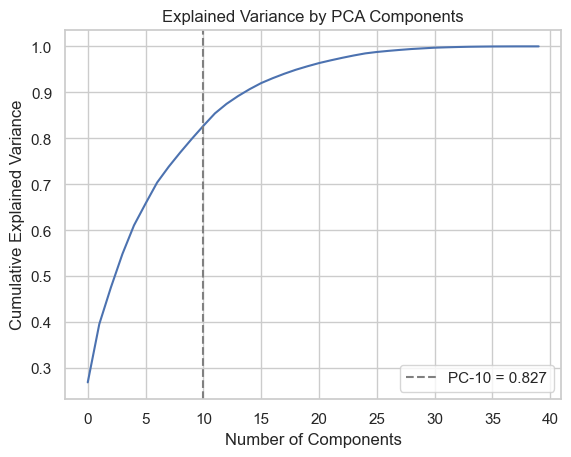

Top features in PCA Component 1: []
Top features in PCA Component 2: ['RBC Day 0']
Top features in PCA Component 3: ['Gender']
Top features in PCA Component 4: ['%GRA Day 0', 'IL-15']
Top features in PCA Component 5: ['MCP-1', 'Eotaxin']
Top features in PCA Component 6: ['MDC']
Top features in PCA Component 7: ['MDC', 'IP-10']
Top features in PCA Component 8: ['%MON Day 0']
Top features in PCA Component 9: ['HSV1_2.Status', 'IL-8']
Top features in PCA Component 10: ['IL-8']
Selected Features: ['IL-15', 'HSV1_2.Status', 'RBC Day 0', 'IL-8', 'Gender', '%MON Day 0', 'MDC', 'Eotaxin', '%GRA Day 0', 'IP-10', 'MCP-1']
Original Dataset Class Distribution:
Counter({'no response': 29, 'response': 11})

Training Set Class Distribution:
Counter({'no response': 23, 'response': 9})

Test Set Class Distribution:
Counter({'no response': 6, 'response': 2})
--------------------------------------------------


Performance Metrics:
Full Feature Set Mean CV Balanced Accuracy: 0.4550
Full Feature Set Mean 

In [241]:
selected_features, _ = pca_feature_selection(merged_data, n_components=10, feature_loading_threshold=0.30, plot_variance=True)
results = evaluate_feature_sets(merged_data, reduced_features=selected_features)

In [242]:
#looking at correlation_heatmap_merged_ward2.png

# Define the groups of correlated features
group_1 = ['IL1Ra', 'TNFb', 'MCP3', 'IL-13']
group_2 = ['IL-9', 'IL-10', 'GM-CSF', 'IL-2','IL-7', 'IFNa2']
group_3 = ['Gender', 'RBC Day 0', 'HGB Day 0', 'HCT Day 0']
group_4 = ['IL12-p70', 'IFNg', 'IL17A', 'TGF-a', 'TNFa','MIP1b', 'FGF-2', 'VEGF']
group_5 = ['Fractalkine', 'IL-15', 'IL-1b']

# Partial Least Squares Regression (PLS) would be the most appropriate method. PLS not only reduces dimensionality but also ensures that the new components are most predictive of your target variable.
def compress_features(data, features, target, new_feature_name, n_components=1):
    # Ensure the target is not among the features
    features = [feat for feat in features if feat != target]
    
    # Check if features exist in the data
    missing_features = [feat for feat in features if feat not in data.columns]
    if missing_features:
        raise ValueError(f"The following features are missing from the data: {missing_features}")
    
    # Prepare the feature matrix X and target vector y
    X = data[features]
    y = data[target]
    
    # Handle missing values
    if X.isnull().any().any() or y.isnull().any():
        raise ValueError("Missing values detected. Please handle them before proceeding.")
    
    # Encode target variable if it's categorical
    if y.dtype == 'object' or isinstance(y.dtype, pd.CategoricalDtype):
        le = LabelEncoder()
        y = le.fit_transform(y)
        
    # Convert y to 2D array (required by scikit-learn)
    y = np.array(y).reshape(-1, 1)
    
    # Initialize and fit the PLS regression model
    pls = PLSRegression(n_components=n_components)
    pls.fit(X, y)
    
    # Transform the features
    X_transformed = pls.transform(X)
    
    # Add the new compressed feature to the data
    data[new_feature_name] = X_transformed[:, 0]
    
    return data


merged_data_compressed_correlated = merged_data.copy()
# Compress the groups and create new features
merged_data_compressed_correlated = compress_features(merged_data_compressed_correlated, group_1, 'response_label', 'Group_1_Compressed')
merged_data_compressed_correlated = compress_features(merged_data_compressed_correlated, group_2, 'response_label', 'Group_2_Compressed')
merged_data_compressed_correlated = compress_features(merged_data_compressed_correlated, group_3, 'response_label', 'Group_3_Compressed')
merged_data_compressed_correlated = compress_features(merged_data_compressed_correlated, group_4, 'response_label', 'Group_4_Compressed')
merged_data_compressed_correlated = compress_features(merged_data_compressed_correlated, group_5, 'response_label', 'Group_5_Compressed')

# Drop the original features that are now compressed
merged_data_compressed_correlated.drop(columns=group_1 + group_2 + group_3 + group_4 + group_5, inplace=True)

Partial Least Squares Regression:
- Wold, H. (1985). Partial least squares. Encyclopedia of Statistical Sciences, 6.
- Abdi, H. (2010). Partial least squares regression and projection on latent structure regression (PLS Regression). Wiley Interdisciplinary Reviews: Computational Statistics, 2(1), 97-106.
Scikit-learn Documentation:
- PLSRegression Documentation
Data Preprocessing Techniques:
- Kuhn, M., & Johnson, K. (2013). Applied Predictive Modeling. Springer.

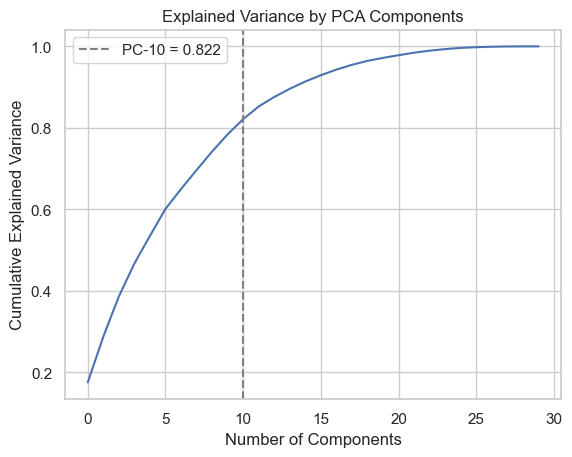

Top features in PCA Component 1: ['Group_4_Compressed', 'MIP1a']
Top features in PCA Component 2: ['EGF']
Top features in PCA Component 3: ['Group_5_Compressed']
Top features in PCA Component 4: ['MCP-1', 'Eotaxin']
Top features in PCA Component 5: ['Group_3_Compressed', 'CMV.Status', 'IL1a']
Top features in PCA Component 6: ['MDC', 'IP-10']
Top features in PCA Component 7: ['IL12-p40']
Top features in PCA Component 8: ['GCSF', 'Age']
Top features in PCA Component 9: ['IL-8']
Top features in PCA Component 10: ['IL12-p40', 'HSV1_2.Status', 'GRO']
Selected Features: ['Group_3_Compressed', 'Group_5_Compressed', 'HSV1_2.Status', 'IL-8', 'IL12-p40', 'MIP1a', 'EGF', 'CMV.Status', 'IL1a', 'Age', 'Group_4_Compressed', 'MDC', 'Eotaxin', 'IP-10', 'MCP-1', 'GRO', 'GCSF']
Original Dataset Class Distribution:
Counter({'no response': 29, 'response': 11})

Training Set Class Distribution:
Counter({'no response': 23, 'response': 9})

Test Set Class Distribution:
Counter({'no response': 6, 'response': 

In [243]:
selected_features, _ = pca_feature_selection(merged_data_compressed_correlated, n_components=10, feature_loading_threshold=0.33, plot_variance=True)
results = evaluate_feature_sets(merged_data_compressed_correlated, reduced_features=selected_features)

#### Recursive Feature Elimination Preparation

In [244]:
def remove_features_with_low_variance(variance_threshold, data):
    # Apply VarianceThreshold on the data after removing high-missingness columns
    selector = VarianceThreshold(variance_threshold)
    all_data_filtered = pd.DataFrame(selector.fit_transform(data), columns=data.columns[selector.get_support()])
    
    print("Features removed due to low variance:", set(all_data_filtered.columns) - set(data.columns))
    print("Remaining features after low variance filtering:", all_data_filtered.columns)

remove_features_with_low_variance(0.01 ,cytokines_data)
remove_features_with_low_variance(0.01, cyto_data)

Features removed due to low variance: set()
Remaining features after low variance filtering: Index(['EGF', 'FGF-2', 'Eotaxin', 'TGF-a', 'GCSF', 'Flt3 Ligand', 'GM-CSF',
       'Fractalkine', 'IFNa2', 'IFNg', 'GRO', 'IL-10', 'MCP3', 'IL12-p40',
       'MDC', 'IL12-p70', 'IL-13', 'IL-15', 'sCD40L', 'IL17A', 'IL1Ra', 'IL1a',
       'IL-9', 'IL-1b', 'IL-2', 'IL-5', 'IL-6', 'IL-7', 'IL-8', 'IP-10',
       'MCP-1', 'MIP1a', 'MIP1b', 'TNFa', 'TNFb', 'VEGF'],
      dtype='object')
Features removed due to low variance: set()
Remaining features after low variance filtering: Index(['WBC Day 0', 'RBC Day 0', 'HGB Day 0', 'HCT Day 0', 'PLT Day 0'], dtype='object')


#### 2. Initial Feature Importance Assessment

In [245]:
def univariate_feature_analysis(data):
    # Merge the antibody titer data with the additional feature data
    merged_data = pd.merge(abtiters, data, on='Vaccinee')
    
    # Separate the merged data into high and low response groups
    high_response = merged_data[merged_data['response_label'] == 'response']
    low_response = merged_data[merged_data['response_label'] == 'no response']

    # Initialize a dictionary to store p-values for each feature
    results = {}

    # Perform the appropriate statistical test for each feature
    for column in data.columns:
        if column not in ['Vaccinee', 'response_label']:  # Exclude non-feature columns
            
            # Determine the type of test based on data type
            if pd.api.types.is_numeric_dtype(merged_data[column]) and merged_data[column].nunique() > 2:
                # Continuous feature: use ANOVA
                f_stat, p_value = f_oneway(high_response[column], low_response[column])
                results[column] = p_value
            elif isinstance(merged_data[column].dtype, pd.CategoricalDtype) or merged_data[column].nunique() == 2:
                # Categorical (binary) feature: use chi-squared test
                contingency_table = pd.crosstab(merged_data[column], merged_data['response_label'])
                chi2, p_value, dof, expected = chi2_contingency(contingency_table)
                results[column] = p_value

    # Filter features with significant differences (e.g., p < 0.05)
    significant_features = [feature for feature, p in results.items() if p < 0.05]
    
    print("Significant features (p < 0.05):", significant_features)

univariate_feature_analysis(cytokines)
univariate_feature_analysis(cytometry)
univariate_feature_analysis(metadata)

Significant features (p < 0.05): []
Significant features (p < 0.05): []
Significant features (p < 0.05): []


we know that there are no significantly difference between high and low response groups for the features.


#### 3 Iterative Feature Selection with SHAP

==========cytokines==========
Random Forest Model Accuracy: 0.75


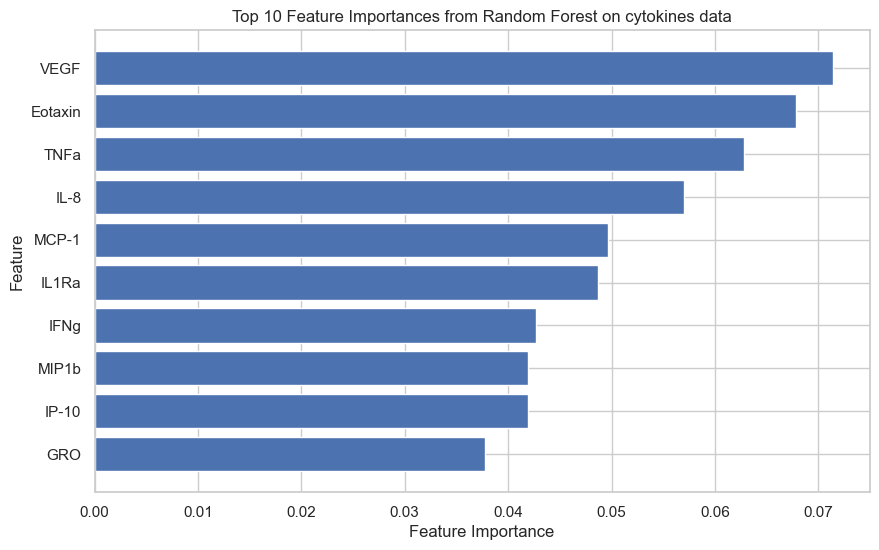

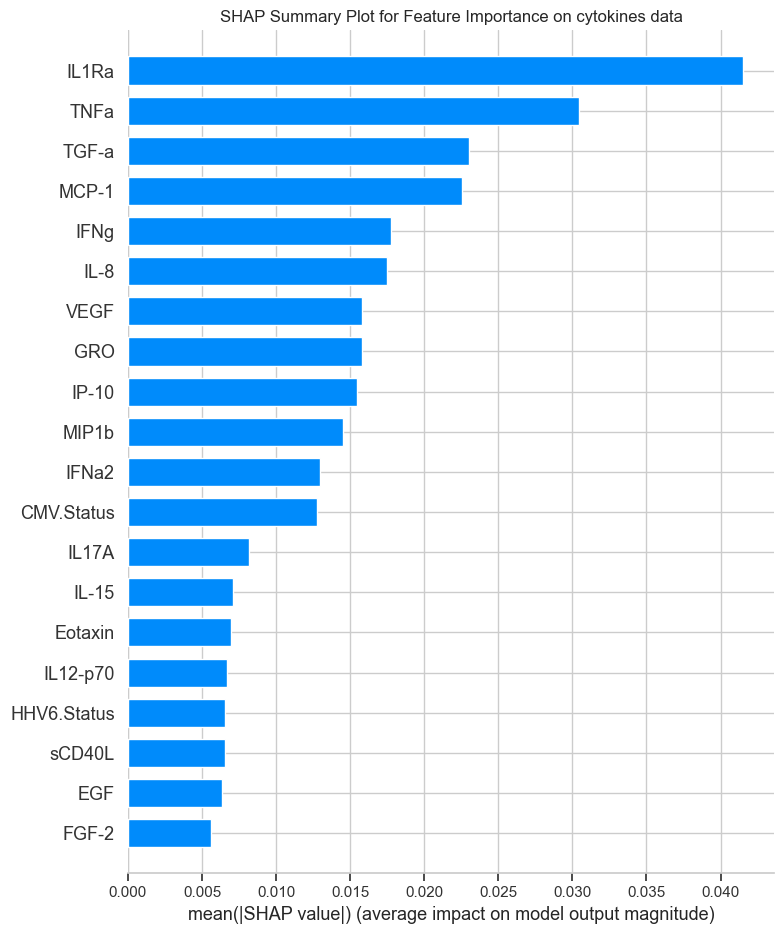

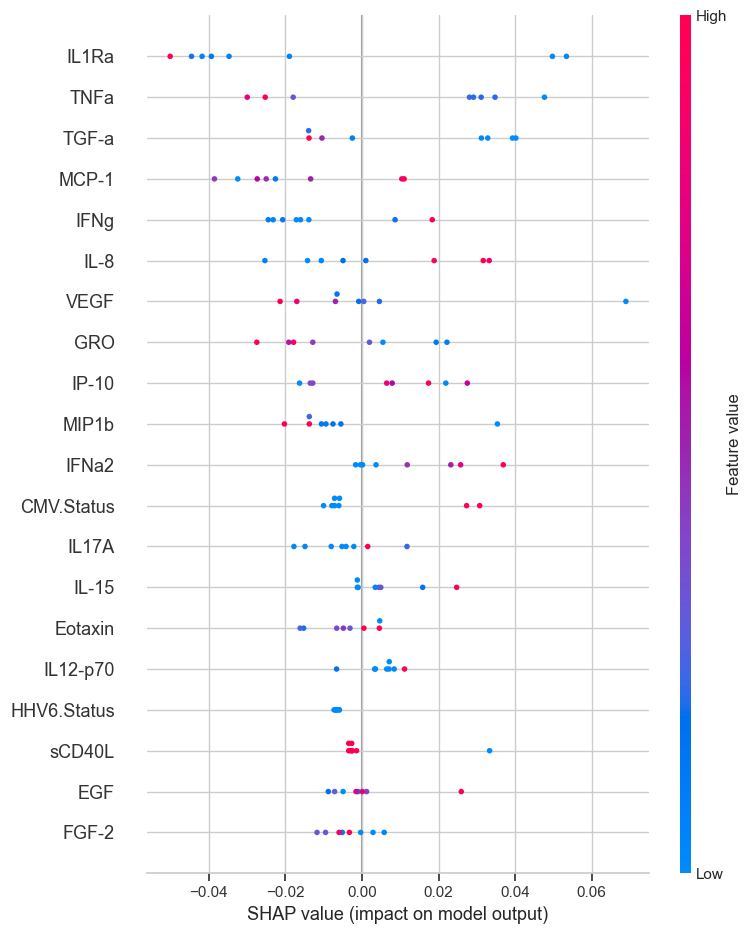

==========cytometry==========
Random Forest Model Accuracy: 0.75


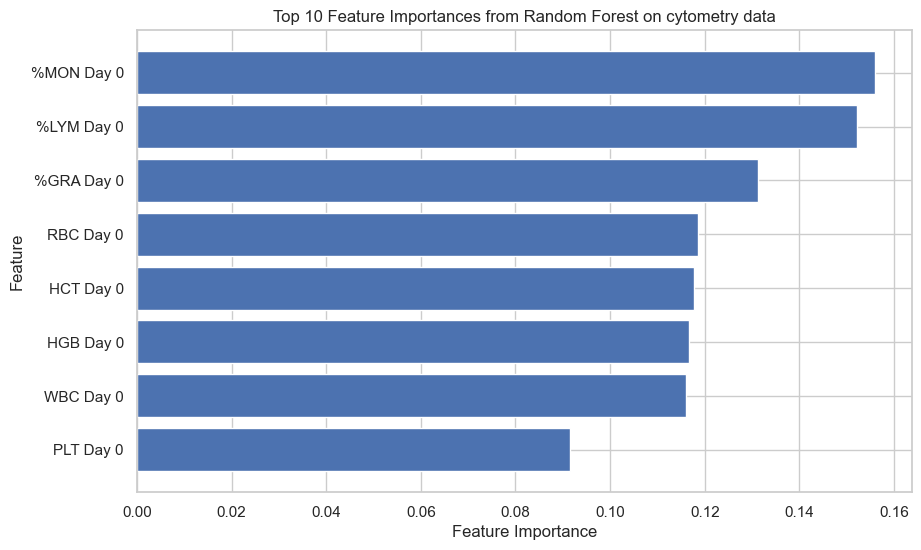

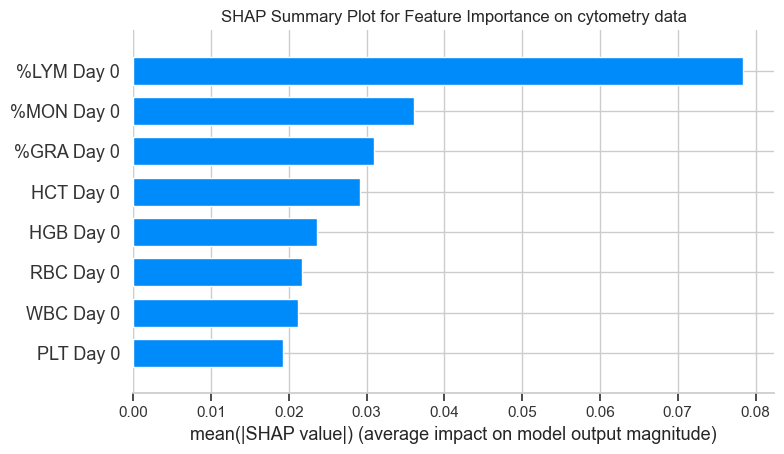

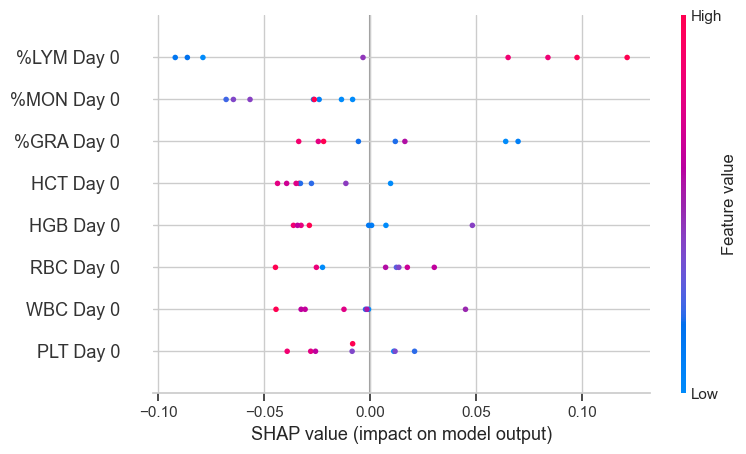

==========metadata==========
Random Forest Model Accuracy: 0.38


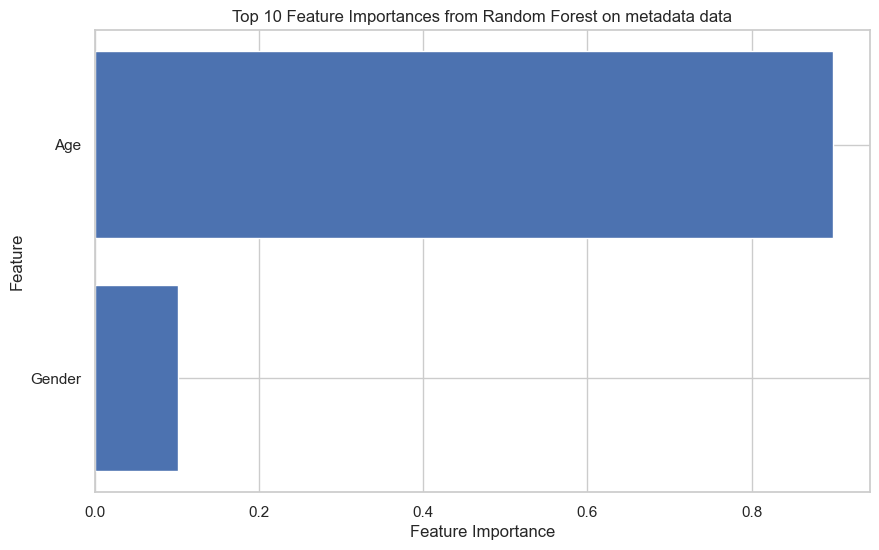

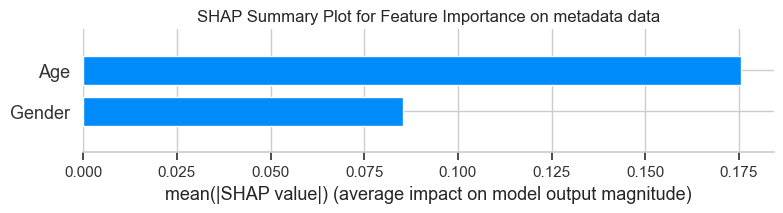

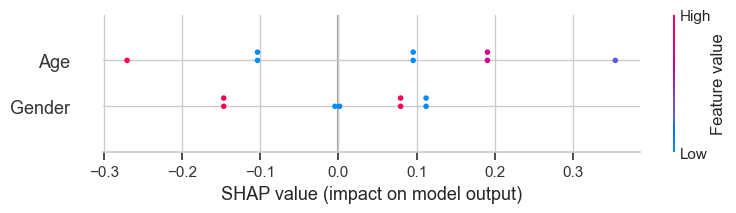

==========cytokines,metadata,cytometry==========
Random Forest Model Accuracy: 0.75


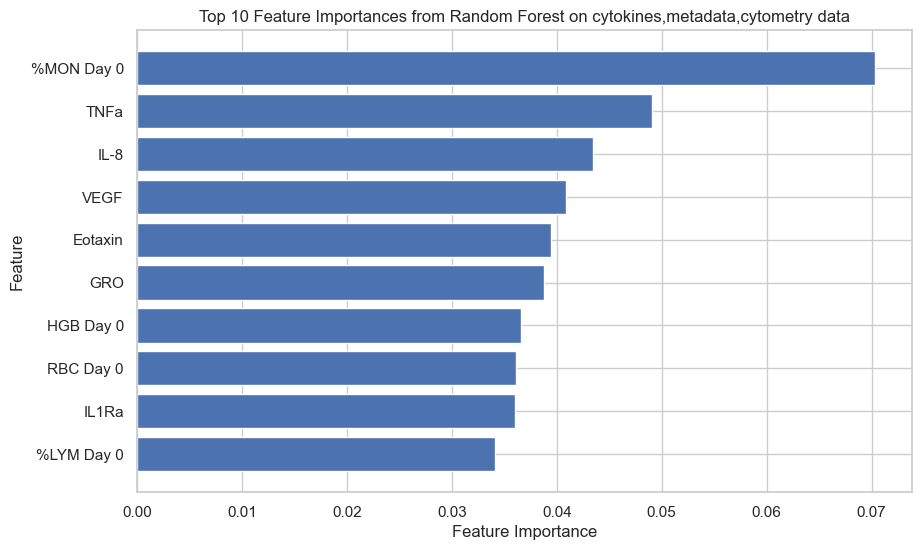

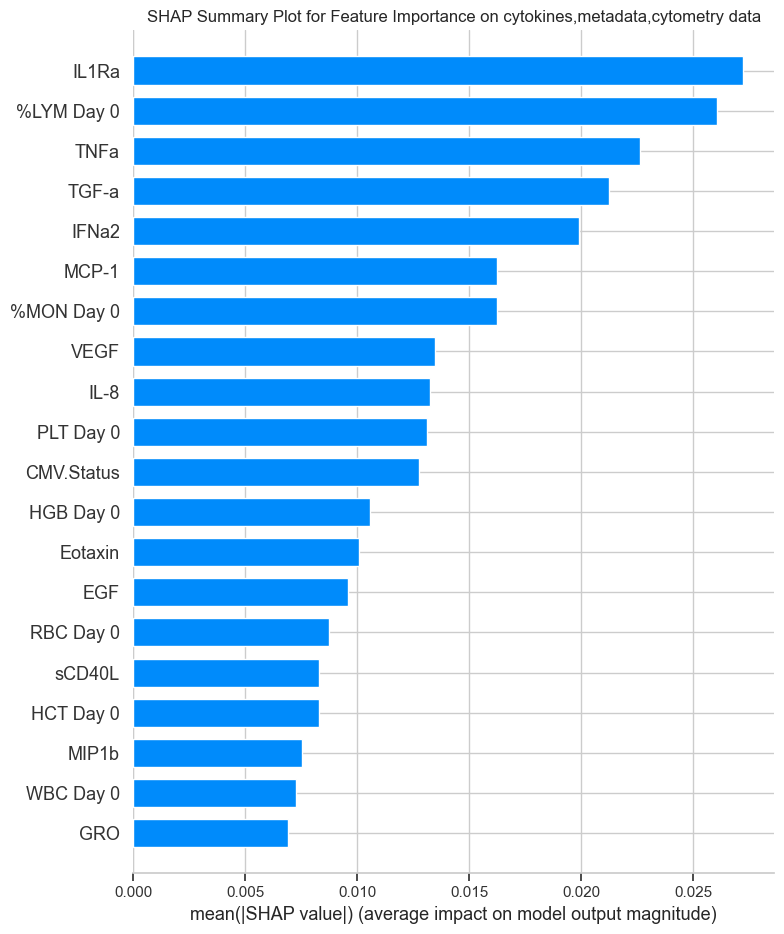

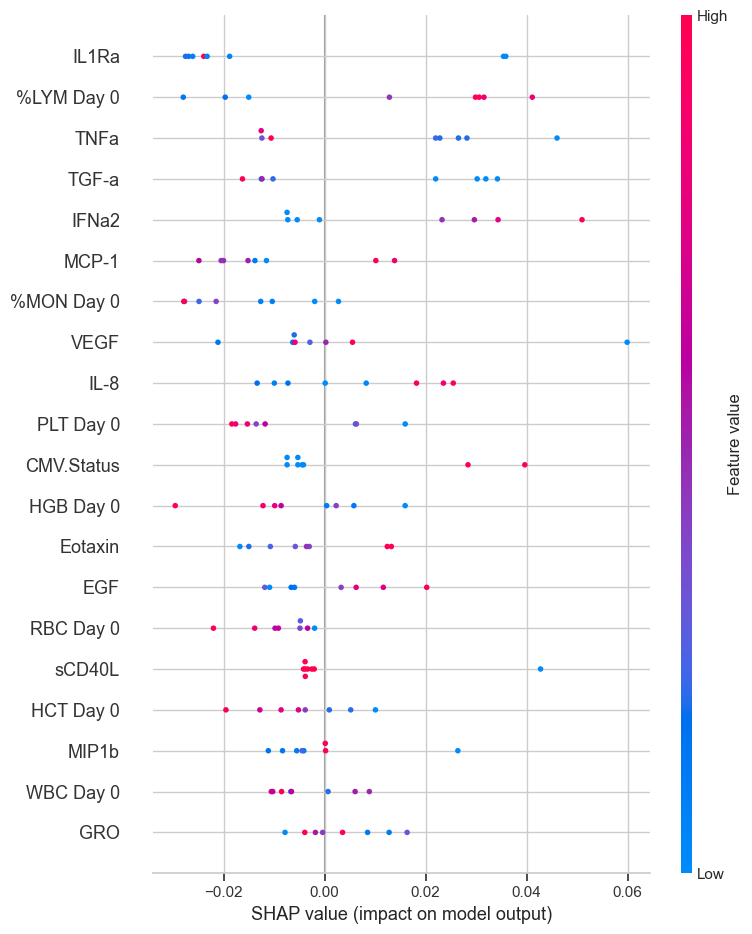

In [246]:
def random_forest_for_baseline_importance(data, title=""):
    # Prepare data for Random Forest (X = features, y = response_label)
    merged_data = pd.merge(abtiters, data, on='Vaccinee')
    X = merged_data.drop(columns=['Vaccinee', 'response_label'])
    y = merged_data['response_label']
   
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize and fit the Random Forest Classifier
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Calculate accuracy on test data
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Random Forest Model Accuracy: {accuracy:.2f}")
    
    # Get feature importances from the model
    feature_importances = rf_model.feature_importances_
    
    # Sort features by importance and display top 10
    important_features = sorted(zip(X.columns, feature_importances), key=lambda x: x[1], reverse=True)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh([feature for feature, _ in important_features[:10]], 
             [importance for _, importance in important_features[:10]])
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title(f"Top 10 Feature Importances from Random Forest on {title} data")
    plt.gca().invert_yaxis()
    plt.show()
    
    # SHAP Analysis
    explainer = shap.TreeExplainer(rf_model, X_train)
    shap_values = np.array(explainer.shap_values(X_test, check_additivity=False))
    shap_values_ = shap_values.transpose((2, 0, 1)) 
   
    # Summary plot for SHAP values
    plt.title(f"SHAP Summary Plot for Feature Importance on {title} data")
    shap.summary_plot(shap_values_[1], X_test, plot_type="bar")  # Assuming binary classification
    shap.summary_plot(shap_values_[1], X_test)  # Full SHAP summary plot



print(f'{"="*10}cytokines{"="*10}')
random_forest_for_baseline_importance(cytokines, title="cytokines")
print(f'{"="*10}cytometry{"="*10}')
random_forest_for_baseline_importance(cytometry, title="cytometry")
print(f'{"="*10}metadata{"="*10}')
random_forest_for_baseline_importance(metadata, title="metadata")

print(f'{"="*10}cytokines,metadata,cytometry{"="*10}')
cytokines_cyto = pd.merge(cytokines, cytometry, on='Vaccinee')
all_merged = pd.merge(cytokines_cyto, metadata, on='Vaccinee')
random_forest_for_baseline_importance(all_merged, title="cytokines,metadata,cytometry")


1. Cytokines Data
- Top Random Forest Important Features: MCP-1, Eotaxin, TNFa, MIP1b, and GRO stand out as the most important features. MCP-1 has the highest feature importance score, indicating it is critical in predicting the response.
- SHAP Analysis: The SHAP values show MCP-1 and MIP1b as leading contributors, followed by TGF-a and IL1Ra. This aligns with Random Forest importance, affirming that MCP-1 and MIP1b are highly influential.

2. cytometry Data
- Top Random Forest Important Features: %LYM Day 0 and %GRA Day 0 are the most influential, followed closely by HGB Day 0 and PLT Day 0. These features dominate the importance rankings.
- SHAP Analysis: The SHAP summary aligns with Random Forest results, showing %LYM Day 0 and %GRA Day 0 as impactful. This consistency suggests these features play a major role in predicting response.

3. Metadata
- Top Random Forest Important Features: Age has an overwhelming importance, with Gender contributing minimally.
- SHAP Analysis: Similarly, Age has a dominant influence, indicating that it may correlate strongly with response, whereas Gender has a much smaller impact.

4. Combined Sets (cytometry + Metadata and Cytokines + Metadata)
- Random Forest Feature Importance: MCP-1 remains the most critical feature, suggesting its dominant role across datasets. GRO, RBC Day 0, and PLT Day 0 follow, indicating that features from the cytometry data (e.g., RBC, PLT, HGB) are also crucial predictors.
- SHAP Summary Plot: MCP-1 has the highest mean absolute SHAP value, confirming its strong impact on the model’s prediction. %LYM Day 0 and HGB Day 0 from the cytometry set also rank highly, suggesting that lymphocyte and hemoglobin percentages are influential predictors for response.

> MCP-1, %LYM Day 0, HGB Day 0, and GRO stand out as highly impactful features across all metrics (importance and SHAP values).

#### Recursive Feature Elimination

#### Recursive Feature Elimination with SMOTE and cross-validation 
This is not really that representable. So next I'm going to look for the optimal subset of features by combining Recursive Feature Elimination (RFE) with SMOTE and testing two different cross-validation approaches.

Implement Feature Selection Methods:
 - Start with Lasso or RFE as they are straightforward and effective.
Compare Model Performance:
- Use cross-validation to compare the performance of models using all features versus selected features.
Refine Your Feature Set:
- Adjust thresholds or parameters based on model performance and domain knowledge.

In [247]:


def stratified_cv_rfe(X, y, model, param_grid=None, max_features=10, cv_folds=5):
    """
    Perform Stratified K-Fold cross-validation with RFE for feature selection.

    Parameters:
    - X: pd.DataFrame, feature matrix
    - y: pd.Series or np.array, target vector
    - model: estimator object, the model to use for feature selection and classification
    - param_grid: dict, hyperparameter grid for GridSearchCV
    - max_features: int, maximum number of features to select
    - cv_folds: int, number of cross-validation folds

    Returns:
    - results_df: pd.DataFrame containing fold-wise selected features and performance scores
    - feature_counts: Counter object with feature selection frequency
    """
    if param_grid is None:
        param_grid = {}
    
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    results = []
    selected_features_all_folds = []
    
    for fold, (train_idx, test_idx) in enumerate(tqdm(skf.split(X, y), desc="Stratified CV Progress", total=cv_folds)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Define the pipeline
        pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=42)),
            ('scaler', StandardScaler()),
            ('feature_selection', RFE(estimator=model, n_features_to_select=max_features, step=1)),
            ('classification', model)
        ])
        
        # Define GridSearchCV if param_grid is provided
        if param_grid:
            grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='balanced_accuracy', n_jobs=-1)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
        else:
            # Fit the pipeline without hyperparameter tuning
            pipeline.fit(X_train, y_train)
            best_model = pipeline
        
        # Evaluate on the test set
        y_pred = best_model.predict(X_test)
        balanced_score = balanced_accuracy_score(y_test, y_pred)
        score = accuracy_score(y_test, y_pred)
        
        # Retrieve selected features
        selected_features = X.columns[best_model.named_steps['feature_selection'].support_].tolist()
        selected_features_all_folds.append(selected_features)
        
        # Store results
        results.append({
            "fold": fold + 1,
            "selected_features": selected_features,
            "balanced_accuracy": balanced_score,
            "accuracy": score
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Count feature selection frequency
    all_selected_features = [feature for sublist in results_df['selected_features'] for feature in sublist]
    feature_counts = Counter(all_selected_features)
    
    return results_df, feature_counts

# Define Function to Plot Feature Selection Frequency Heatmap
def plot_feature_selection_heatmap(selected_features_list, stable_features):
    """
    Plot a heatmap showing the frequency of feature selection across folds.

    Parameters:
    - selected_features_list: list of lists, each sublist contains selected features for a fold
    - stable_features: list, features selected more than the threshold
    """
    # Create a presence matrix
    presence_matrix = pd.DataFrame(0, index=range(1, len(selected_features_list) + 1), columns=stable_features)
    
    for fold_idx, features in enumerate(selected_features_list, start=1):
        for feature in features:
            if feature in stable_features:
                presence_matrix.at[fold_idx, feature] = 1
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(presence_matrix, cmap="crest", cbar=False, linewidths=.5, annot=True, fmt="d")
    plt.title("Feature Selection Frequency Heatmap")
    plt.xlabel("Stable Features")
    plt.ylabel("Fold")
    plt.show()

# Define Function to Plot Overall Model Performance
def plot_overall_performance(results_df):
    """
    Plot the overall model performance across folds.

    Parameters:
    - results_df: pd.DataFrame, containing 'balanced_accuracy' per fold
    """
    plt.figure(figsize=(8, 6))
    sns.barplot(data=results_df, x='fold', y='balanced_accuracy', hue='fold', palette='viridis')
    plt.ylim(0, 1)
    plt.xlabel('Fold')
    plt.ylabel('Balanced Accuracy')
    plt.title('Model Performance Across Folds')
    plt.show()

# Define Function to Plot Feature Importances
def plot_feature_importances(model, feature_names, top_n=10):
    """
    Plot the top N feature importances from the model.

    Parameters:
    - model: fitted estimator with 'feature_importances_' attribute
    - feature_names: list, names of the features
    - top_n: int, number of top features to display
    """
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
        importance_df = importance_df.sort_values(by='importance', ascending=False).head(top_n)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(
            data=importance_df,
            x='importance',
            y='feature',
            hue='feature',         # Assign 'feature' to hue
            palette='magma'
        )
        plt.title(f"Top {top_n} Feature Importances")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.legend([], [], frameon=False)  # Remove the legend
        plt.show()
    else:
        print("The provided model does not have 'feature_importances_' attribute.")

# Define Function to Plot Feature Importances for Linear Models
def plot_feature_importances_linear(model, feature_names, top_n=10):
    """
    Plot the top N feature importances based on model coefficients.

    Parameters:
    - model: fitted estimator with 'coef_' attribute
    - feature_names: list, names of the features
    - top_n: int, number of top features to display
    """
    if hasattr(model, 'coef_'):
        # For binary classification, coef_ is of shape (1, n_features)
        coef = model.coef_.flatten()
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': np.abs(coef)  # Use absolute value for importance
        })
        importance_df = importance_df.sort_values(by='importance', ascending=False).head(top_n)

        plt.figure(figsize=(10, 6))
        sns.barplot(
            data=importance_df,
            x='importance',
            y='feature',
            hue='feature',        # Assign 'feature' to hue
            palette='magma'
        )
        plt.title(f"Top {top_n} Feature Importances (Logistic Regression)")
        plt.xlabel("Importance (|Coefficient|)")
        plt.ylabel("Feature")
        plt.legend([], [], frameon=False)  # Removes the legend
        plt.show()
    else:
        print("The provided model does not have 'coef_' attribute.")

# Define Function to Run RFE Analysis
def run_rfe_analysis(
    X, 
    y, 
    model, 
    max_features=5, 
    cv_folds=5, 
    threshold=3, 
    output_csv_path='../data_created/cv_rfe_compressed_features_results.csv', 
    top_n_importances=10,
    plot_importances_func=None  # New parameter for custom plotting
):
    """
    Execute the complete RFE analysis workflow.

    Parameters:
    - X: pd.DataFrame, feature matrix
    - y: pd.Series or np.array, target vector
    - model: estimator object, the model to use for feature selection and classification
    - max_features: int, maximum number of features to select
    - cv_folds: int, number of cross-validation folds
    - threshold: int, minimum number of times a feature must be selected to be considered stable
    - output_csv_path: str, path to save the RFE results CSV
    - top_n_importances: int, number of top feature importances to plot
    - plot_importances_func: function, custom function to plot feature importances

    Returns:
    - stable_features: list, features deemed stable based on the threshold
    """
    # Perform Stratified Cross-Validated RFE
    cv_results_rf, feature_counts = stratified_cv_rfe(
        X=X,
        y=y,
        model=model,
        max_features=max_features,
        cv_folds=cv_folds
    )

    # Save the Results to CSV
    cv_results_rf.to_csv(output_csv_path, index=False)

    # Feature Selection Stability Assessment
    stable_features = [feature for feature, count in feature_counts.items() if count >= threshold]

    print("Stable Features:", stable_features)

    # Plot Overall Model Performance
    plot_overall_performance(cv_results_rf)

    # Plot Feature Selection Frequency Heatmap
    plot_feature_selection_heatmap(cv_results_rf['selected_features'].tolist(), stable_features)

    # Fit Final Model on Entire Dataset with Stable Features
    if stable_features:
        final_pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=42)),
            ('scaler', StandardScaler()),
            ('feature_selection', RFE(estimator=model, n_features_to_select=len(stable_features), step=1)),
            ('classification', model)
        ])

        final_pipeline.fit(X, y)
        final_model = final_pipeline.named_steps['classification']

        # Plot Feature Importances using the provided plotting function
        if plot_importances_func:
            plot_importances_func(final_model, stable_features, top_n=min(top_n_importances, len(stable_features)))
        else:
            plot_feature_importances(final_model, stable_features, top_n=min(top_n_importances, len(stable_features)))
    else:
        print("No stable features found based on the threshold.")
        
    return stable_features


In [248]:
# Prepare your data
X = merged_data.drop(columns=['Vaccinee', 'response_label'])
y = merged_data['response_label']

promising_features = {}

#### Methodology:
1. After performing Stratified K-Fold Cross-Validation (e.g., 5-fold), I track how often each feature is selected as important across different training subsets.
2. Features that are selected in multiple folds (exceeding a predefined threshold) are considered stable and important, indicating their robust contribution to the model irrespective of the data split.
3. After identifying stable features, the final model trained on the entire dataset provides feature importance scores (e.g., from RandomForestClassifier.feature_importances_), highlighting which of these stable features have the most significant impact on predictions.

Stratified CV Progress: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it]

Stable Features: ['GRO', 'MCP-1', 'RBC Day 0', 'HGB Day 0', 'HCT Day 0', '%LYM Day 0', '%MON Day 0', '%GRA Day 0', 'IL17A', 'PLT Day 0']


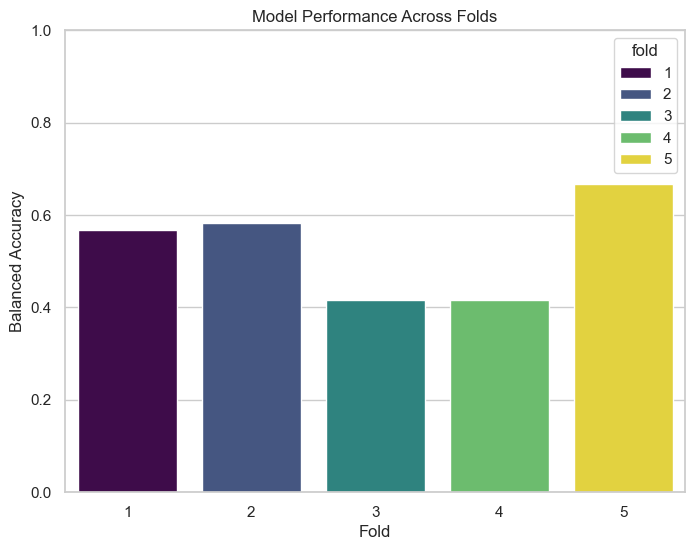

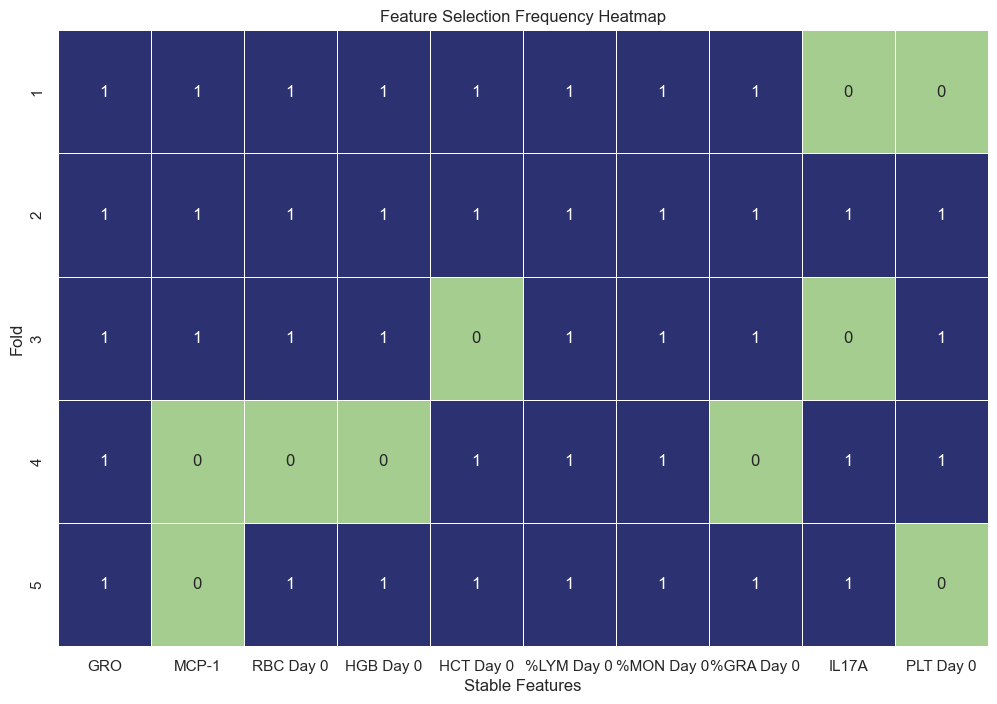

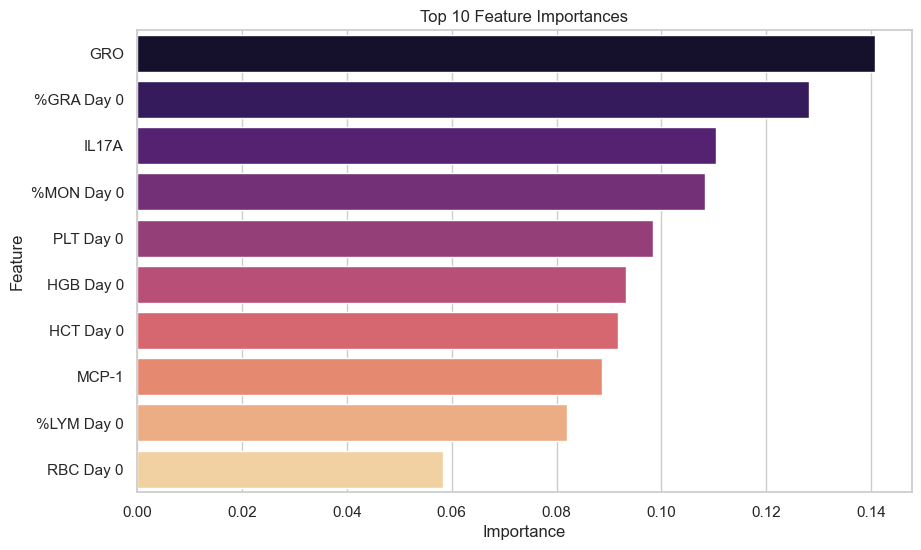

In [249]:
# Define the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

result = run_rfe_analysis(
    X=X,
    y=y,
    model=rf_model,
    max_features=10,
    cv_folds=5,
    threshold=3,
    output_csv_path='../data_created/all_features/cv_rfe_RF_results.csv',
    top_n_importances=10,
    plot_importances_func=plot_feature_importances
)
promising_features["RandomForest"] = result

Stratified CV Progress: 100%|██████████| 5/5 [00:00<00:00, 22.31it/s]

Stable Features: ['IL-8', 'MCP-1', '%MON Day 0', 'HHV6.Status', 'IL1a', 'HGB Day 0', 'VEGF']


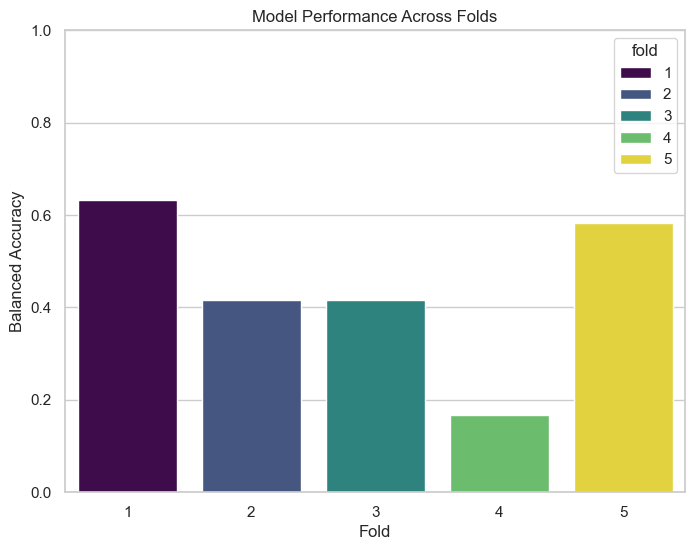

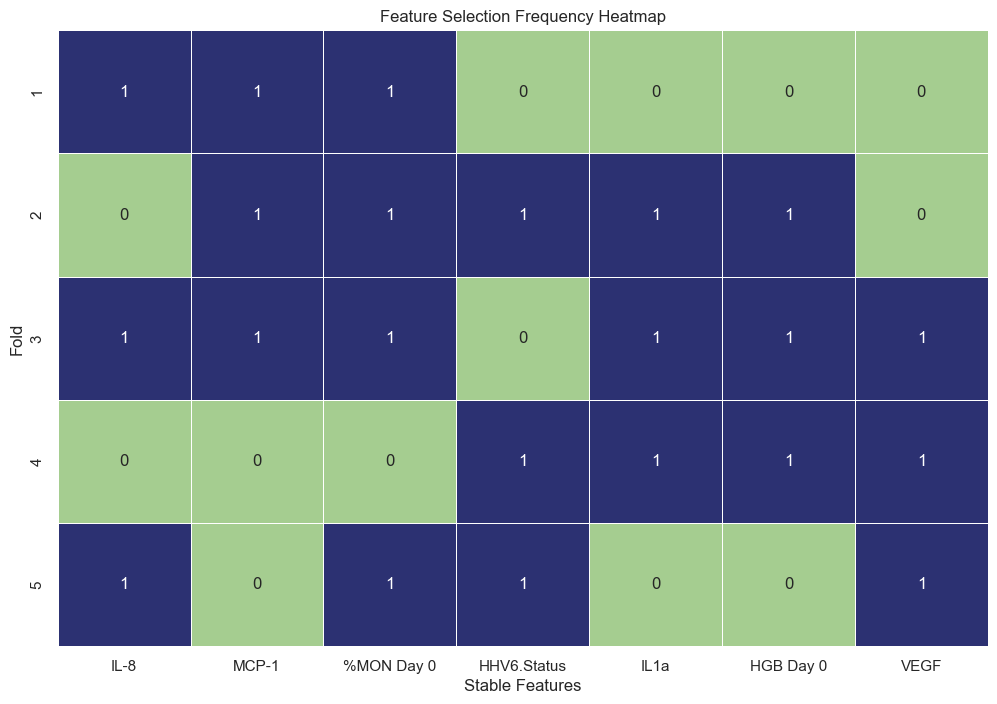

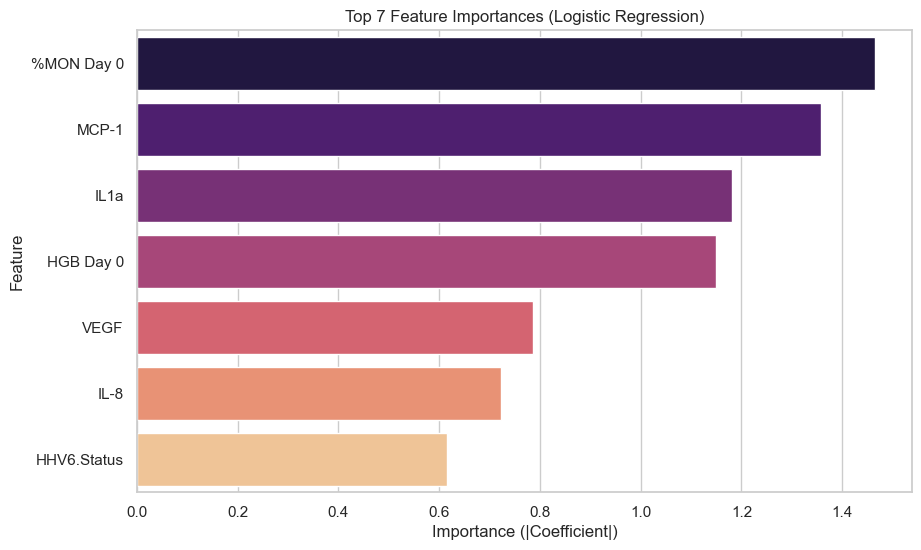

In [250]:
# Initialize the SVM Model
svm_model = SVC(kernel='linear',  probability=True, random_state=42)

result = run_rfe_analysis(
    X=X,
    y=y,
    model=svm_model,
    max_features=10,
    cv_folds=5,
    threshold=3,
    output_csv_path='../data_created/all_features/cv_rfe_SVM_results.csv',
    top_n_importances=10,
    plot_importances_func=plot_feature_importances_linear
)
promising_features["SVM"] = result

Stratified CV Progress: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]

Stable Features: ['GRO', 'HGB Day 0', '%LYM Day 0', '%MON Day 0', 'PLT Day 0', 'RBC Day 0']


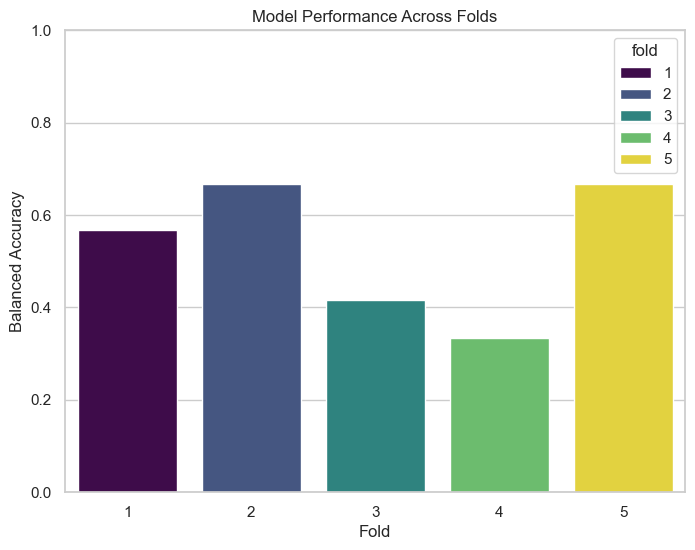

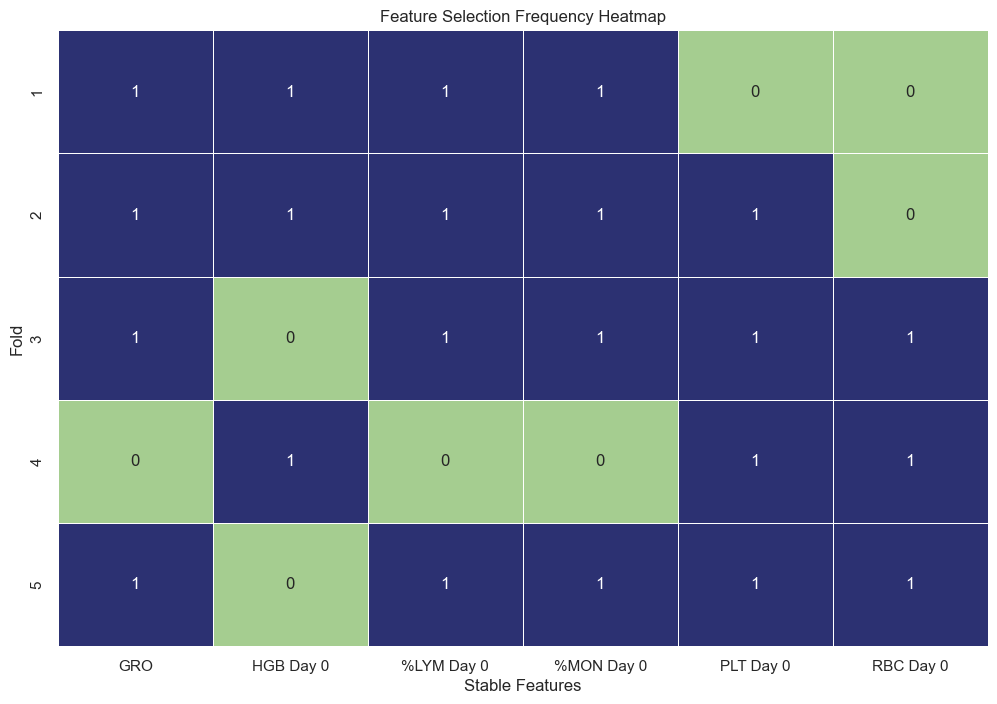

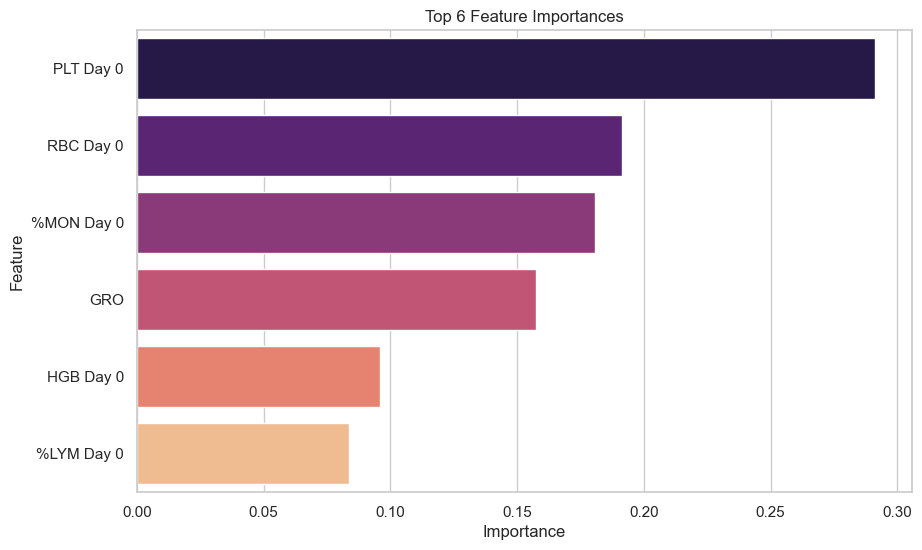

In [251]:
# Initialize the Gradient Boosting Model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

result = run_rfe_analysis(
    X=X,
    y=y,
    model=gb_model,
    max_features=10,
    cv_folds=5,
    threshold=3,
    output_csv_path='../data_created/all_features/cv_rfe_GB_results.csv',
    top_n_importances=10,
    plot_importances_func=plot_feature_importances
)
promising_features["GradientBoosting"] = result

Stratified CV Progress: 100%|██████████| 5/5 [00:00<00:00, 34.41it/s]

Stable Features: ['IL-8', 'IP-10', 'MCP-1', 'VEGF', '%LYM Day 0', '%MON Day 0', 'Gender', 'Age', 'HHV6.Status', 'GCSF']


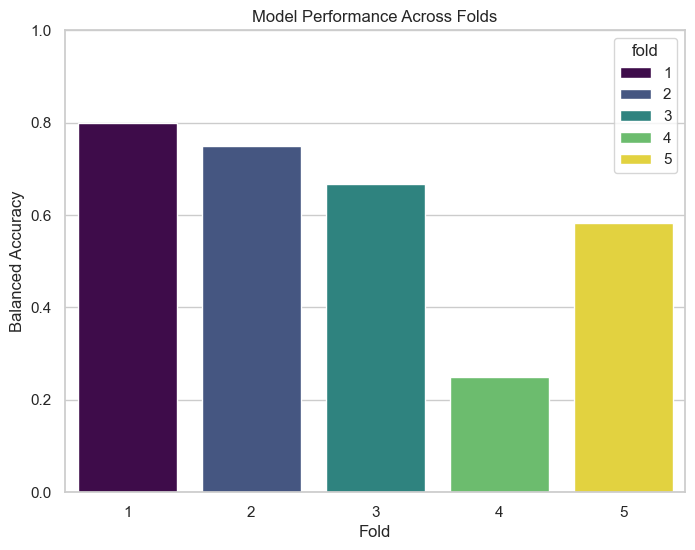

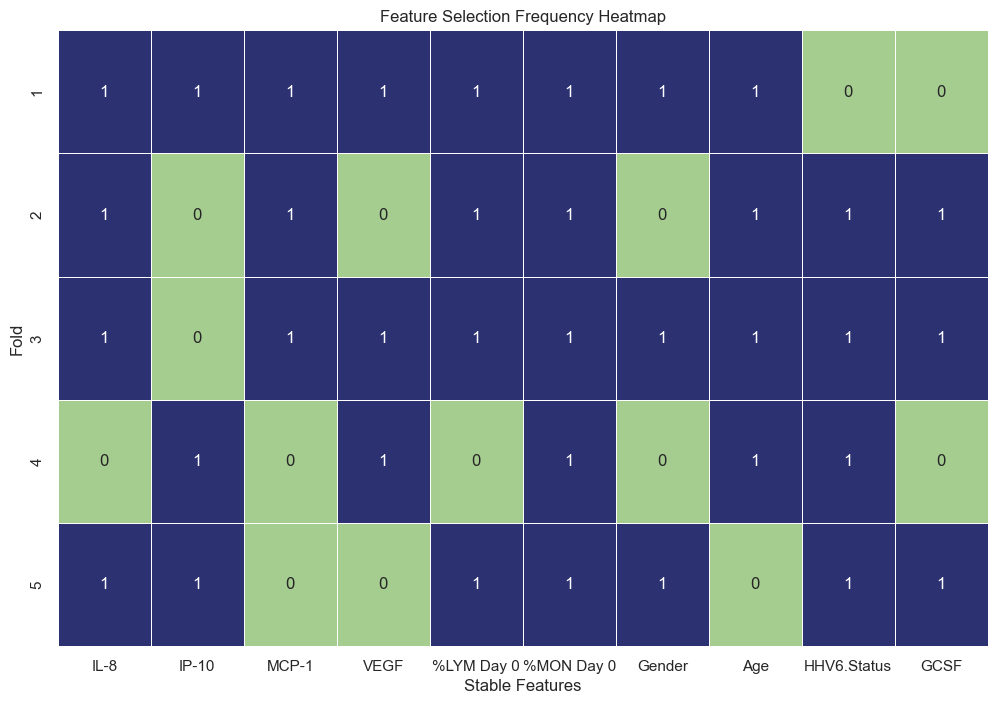

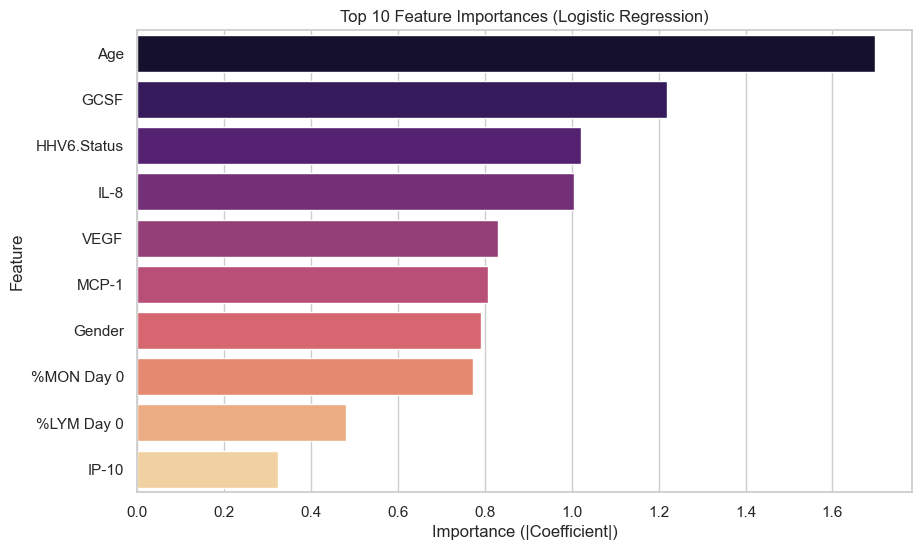

In [252]:
logreg_model = LogisticRegression(penalty='l1', solver='liblinear',  random_state=42)

result = run_rfe_analysis(
    X=X,
    y=y,
    model=logreg_model,
    max_features=10,
    cv_folds=5,
    threshold=3,
    output_csv_path='../data_created/all_features/cv_rfe_LogReg_results.csv',
    top_n_importances=10, 
    plot_importances_func=plot_feature_importances_linear
)
promising_features["LogisticRegression"] = result

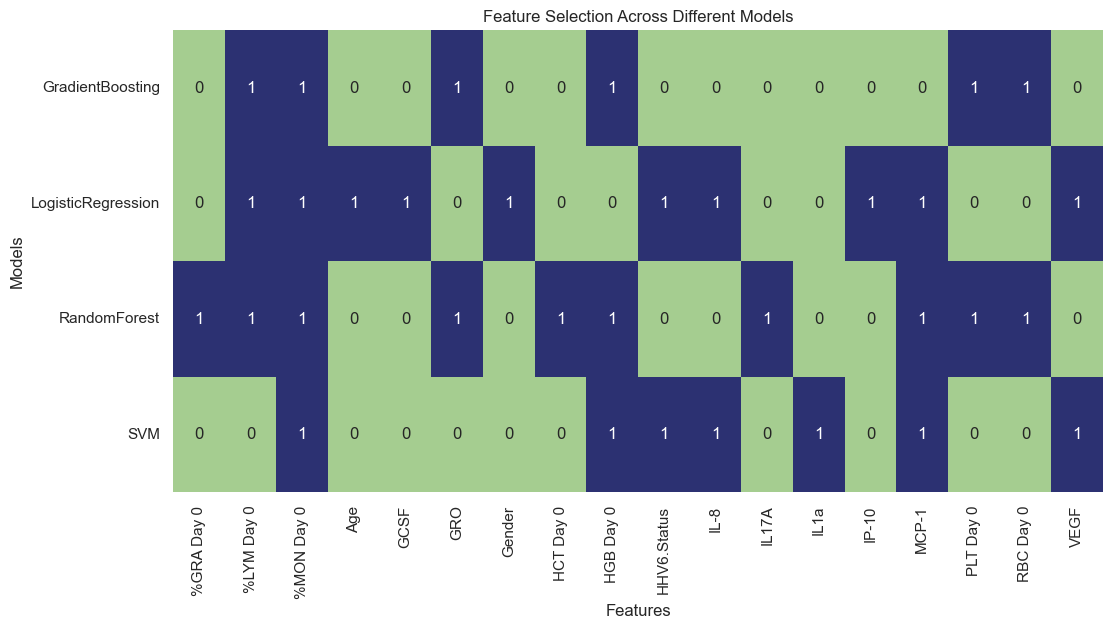

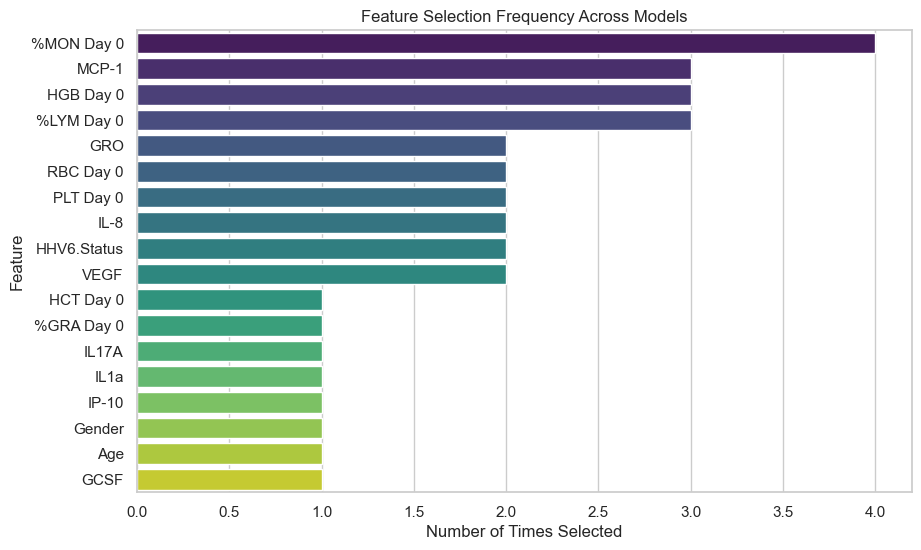

Common Features (selected by multiple models):
- %MON Day 0
- MCP-1
- HGB Day 0
- %LYM Day 0
- GRO
- RBC Day 0
- PLT Day 0
- IL-8
- HHV6.Status
- VEGF

Unique Features (selected by only one model):
- HCT Day 0
- %GRA Day 0
- IL17A
- IL1a
- IP-10
- Gender
- Age
- GCSF


In [253]:
# Step 1: Convert to DataFrame
df_features = pd.DataFrame([(model, feature) for model, features in promising_features.items() for feature in features], columns=['Model', 'Feature'])
df_features.to_csv('../data_created/all_features/cv_rfe_total_results.csv', index=False)

# Step 2: Create pivot table
pivot_df = df_features.pivot_table(index='Model', columns='Feature', aggfunc=len, fill_value=0)

# Step 3: Count feature frequencies
all_features = [feature for features in promising_features.values() for feature in features]
feature_counts = Counter(all_features)
sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)

# Step 4: Plot heatmap
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_df, annot=True, cmap="crest", cbar=False)
plt.title("Feature Selection Across Different Models")
plt.xlabel("Features")
plt.ylabel("Models")
plt.show()

# Step 5a: Bar plot of feature frequencies
df_counts = pd.DataFrame(sorted_features, columns=['Feature', 'Count'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Feature', hue='Feature', data=df_counts, palette='viridis')
plt.title('Feature Selection Frequency Across Models')
plt.xlabel('Number of Times Selected')
plt.ylabel('Feature')
plt.show()

# Step 5b: Summary table of common and unique features
common_features = df_counts[df_counts['Count'] > 1]['Feature'].tolist()
unique_features = df_counts[df_counts['Count'] == 1]['Feature'].tolist()

print("Common Features (selected by multiple models):")
for feature in common_features:
    print(f"- {feature}")

print("\nUnique Features (selected by only one model):")
for feature in unique_features:
    print(f"- {feature}")

#### do the same for compressed data

In [254]:
# Prepare your data
X = merged_data_compressed_correlated.drop(columns=['Vaccinee', 'response_label'])
y = merged_data_compressed_correlated['response_label']

promising_features = {}

Stratified CV Progress: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]

Stable Features: ['GRO', 'MCP-1', 'WBC Day 0', 'PLT Day 0', '%LYM Day 0', '%MON Day 0', '%GRA Day 0', 'Group_3_Compressed', 'IL-8']


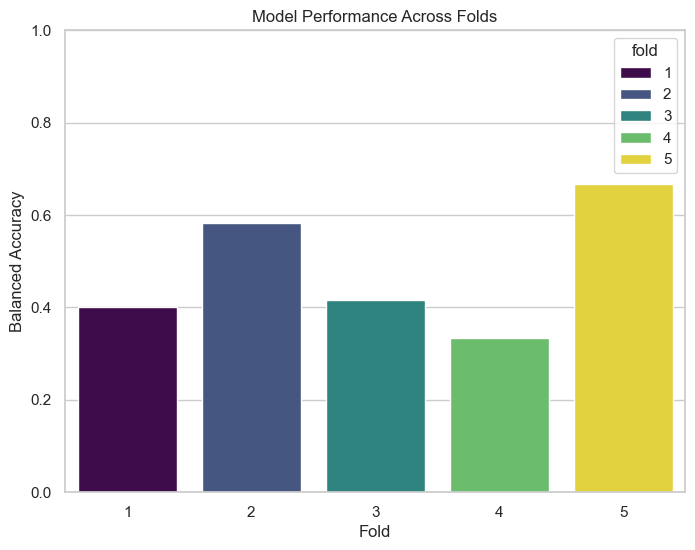

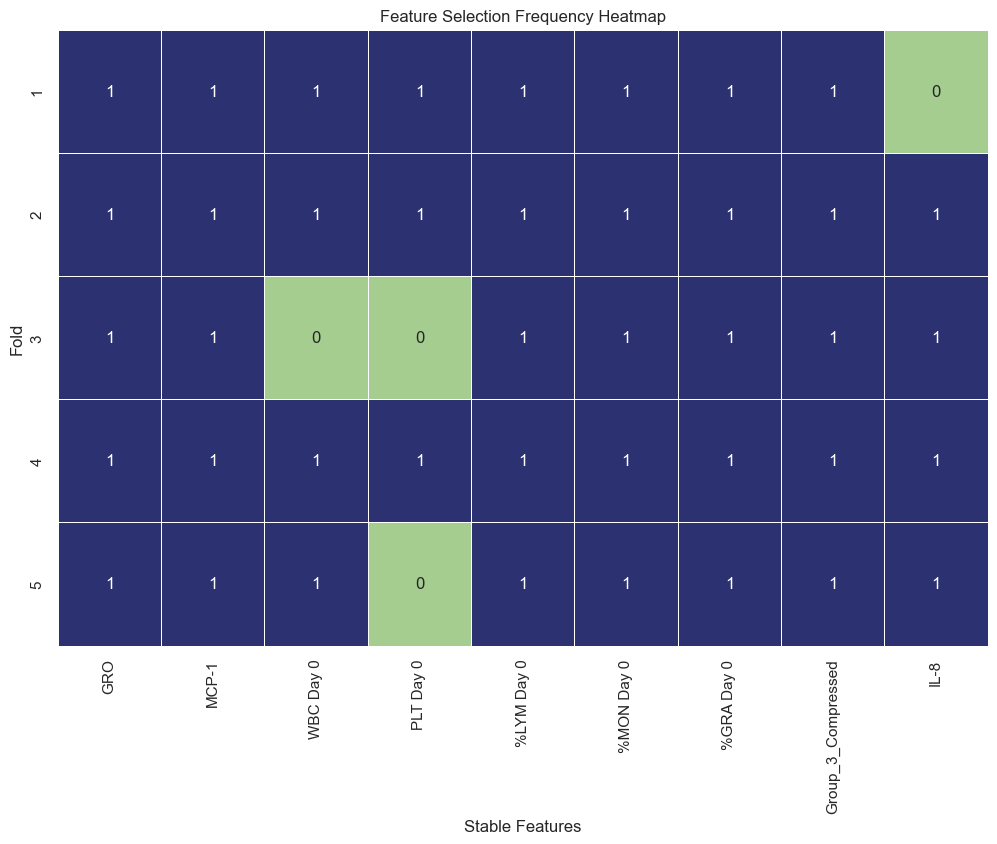

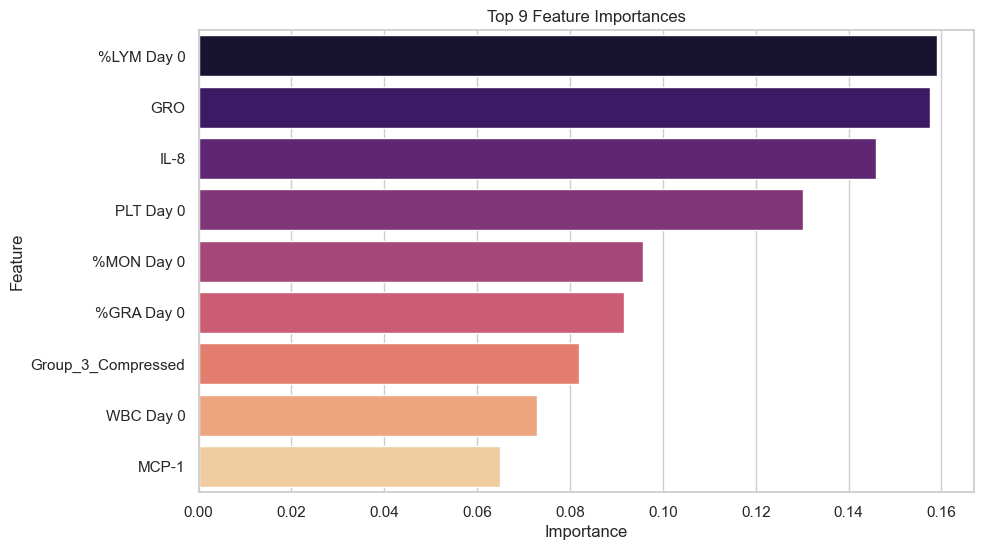

In [255]:
# Define the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Run RFE Analysis
result = run_rfe_analysis(
    X=X,
    y=y,
    model=rf_model,
    max_features=10,
    cv_folds=5,
    threshold=3,
    output_csv_path='../data_created/compressed_features/cv_rfe_RF_results.csv',
    top_n_importances=10,
    plot_importances_func=plot_feature_importances
)
promising_features["RandomForest"] = result

Stratified CV Progress: 100%|██████████| 5/5 [00:00<00:00, 34.21it/s]

Stable Features: ['HHV6.Status', 'IL-8', '%MON Day 0', 'Group_3_Compressed', 'Group_5_Compressed', 'GCSF', 'IL1a', '%LYM Day 0']


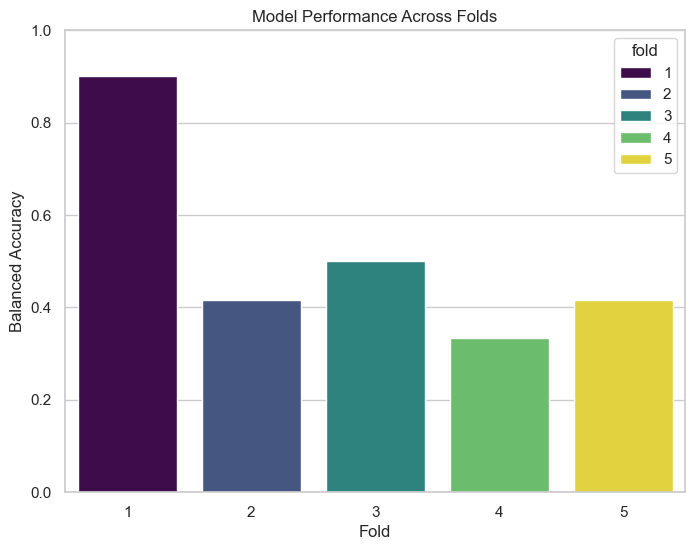

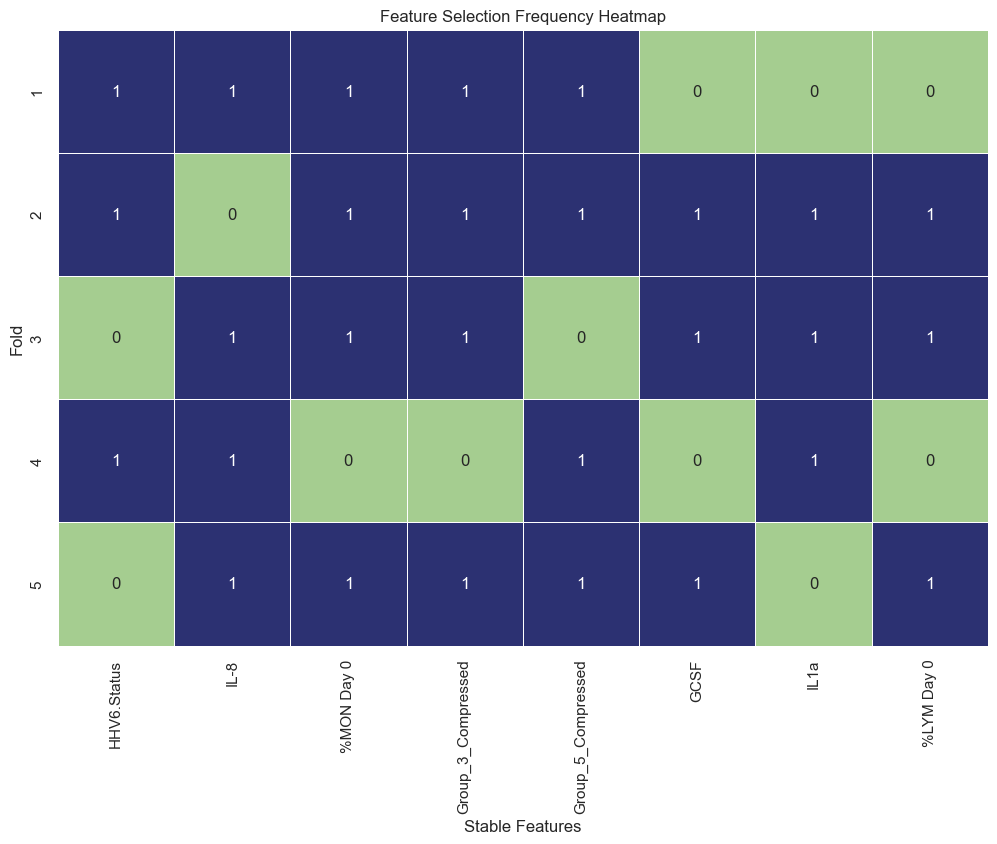

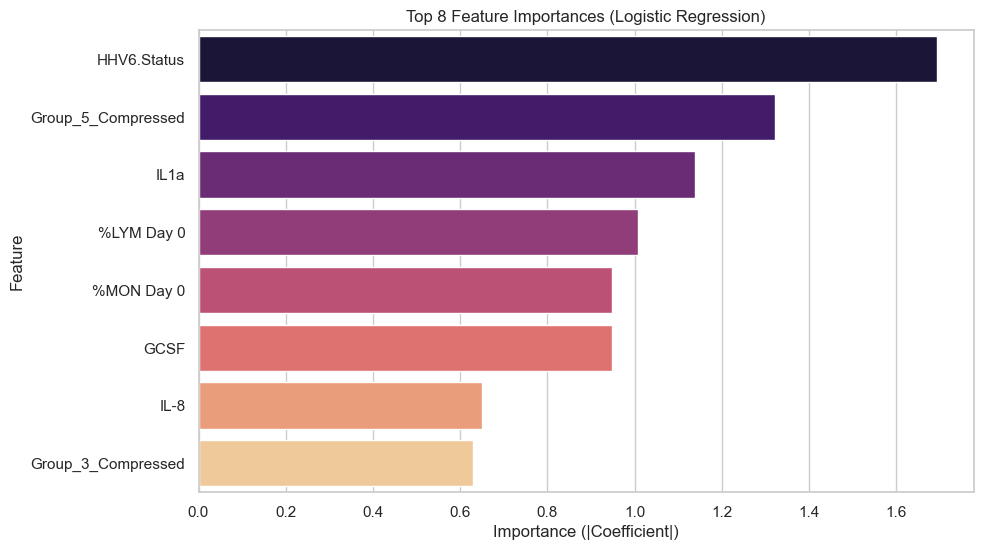

In [256]:
# Initialize the SVM Model
svm_model = SVC(kernel='linear',  probability=True, random_state=42)

result = run_rfe_analysis(
    X=X,
    y=y,
    model=svm_model,
    max_features=10,
    cv_folds=5,
    threshold=3,
    output_csv_path='../data_created/compressed_features/cv_rfe_SVM_results.csv',
    top_n_importances=10,
    plot_importances_func=plot_feature_importances_linear
)
promising_features["SVM"] = result

Stratified CV Progress: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]

Stable Features: ['GRO', 'WBC Day 0', '%LYM Day 0', '%MON Day 0', 'Group_3_Compressed', 'IL-8']


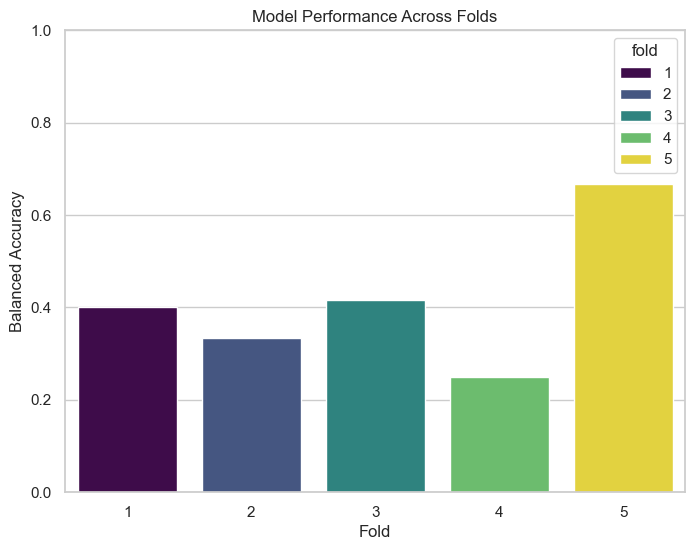

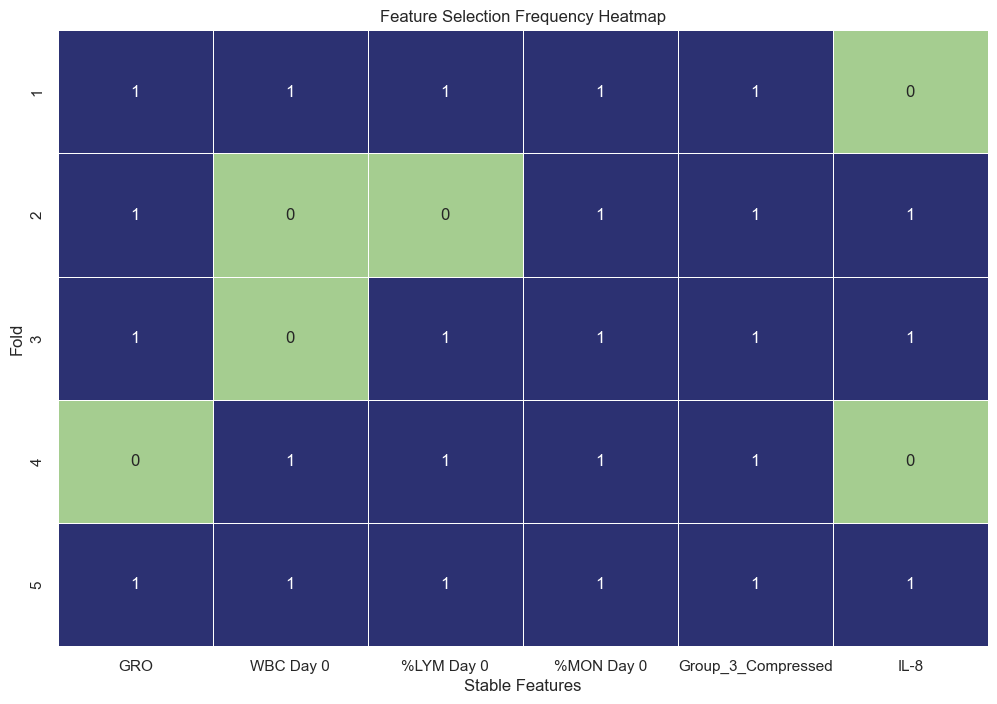

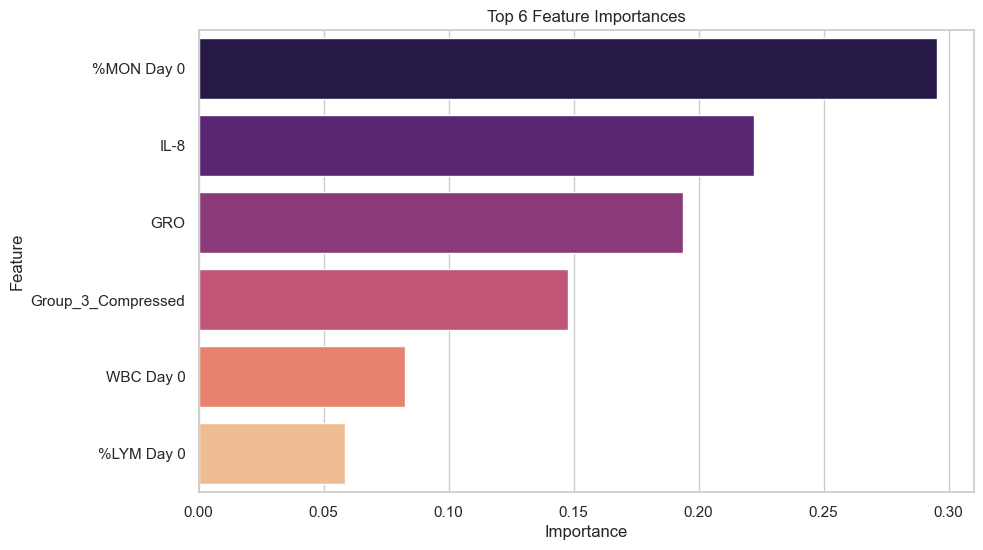

In [257]:
# Initialize the Gradient Boosting Model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

result = run_rfe_analysis(
    X=X,
    y=y,
    model=gb_model,
    max_features=10,
    cv_folds=5,
    threshold=3,
    output_csv_path='../data_created/compressed_features/cv_rfe_GB_results.csv',
    top_n_importances=10,
    plot_importances_func=plot_feature_importances
)
promising_features["GradientBoosting"] = result

Stratified CV Progress: 100%|██████████| 5/5 [00:00<00:00, 58.57it/s]

Stable Features: ['HHV6.Status', 'IL-8', '%MON Day 0', 'Age', 'Group_3_Compressed', 'Group_5_Compressed', '%LYM Day 0']


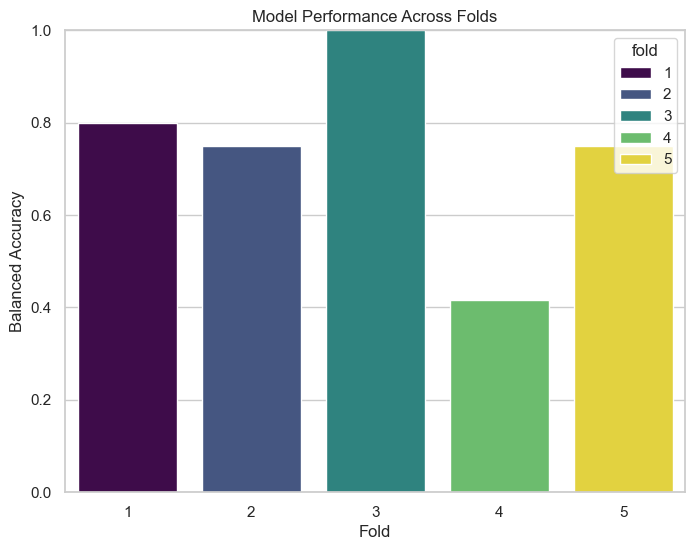

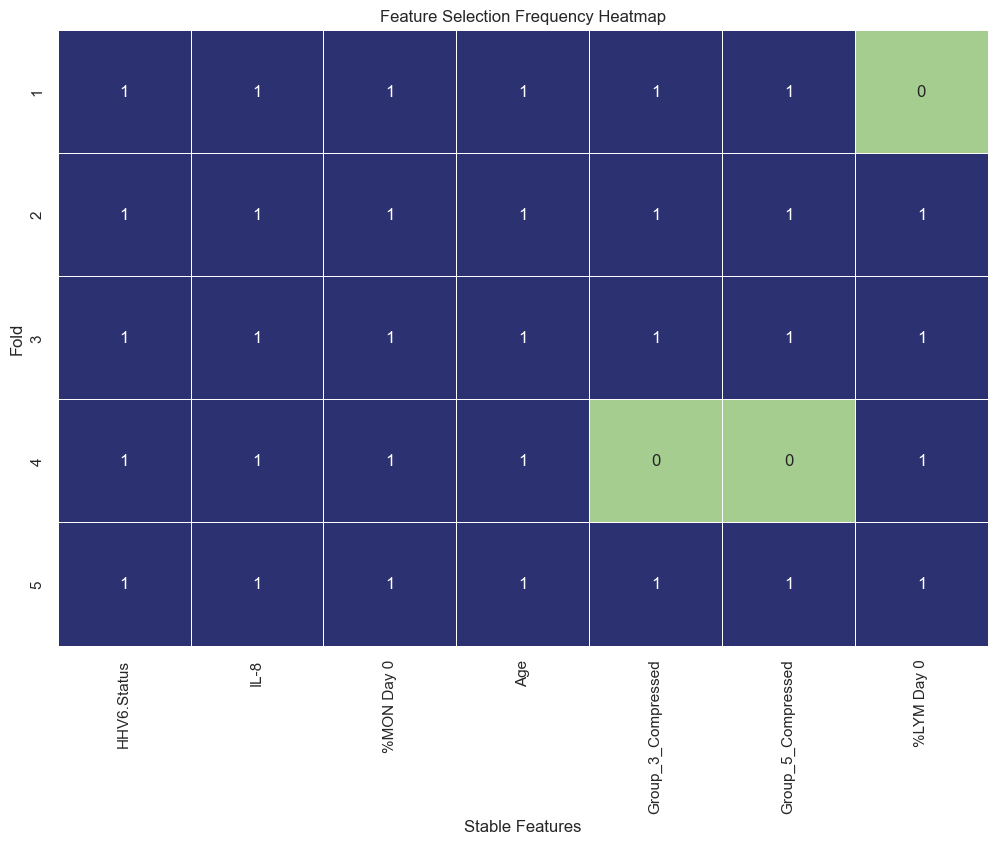

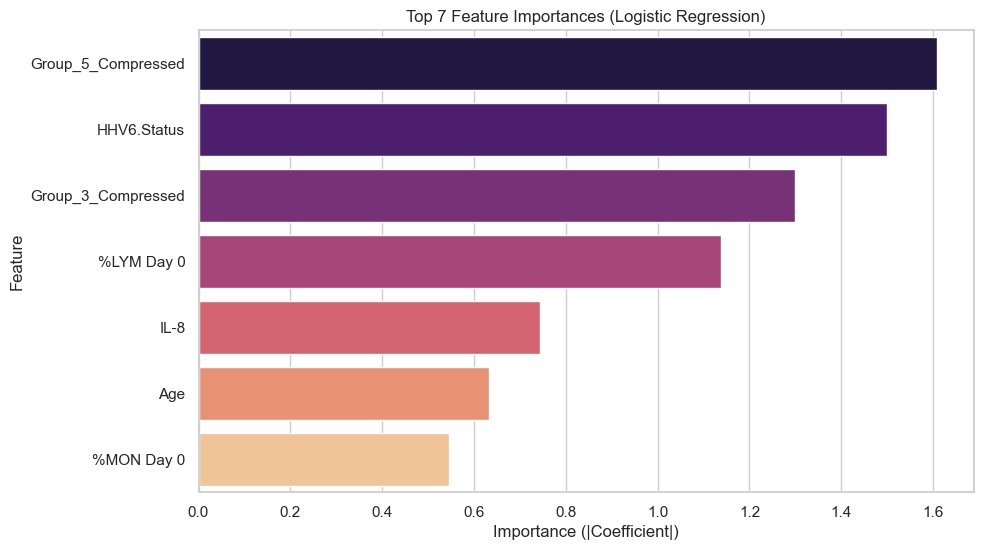

In [258]:
logreg_model = LogisticRegression(penalty='l1', solver='liblinear',  random_state=42)

result = run_rfe_analysis(
    X=X,
    y=y,
    model=logreg_model,
    max_features=10,
    cv_folds=5,
    threshold=3,
    output_csv_path='../data_created/compressed_features/cv_rfe_LogReg_results.csv',
    top_n_importances=10, 
    plot_importances_func=plot_feature_importances_linear
)
promising_features["LogisticRegression"] = result

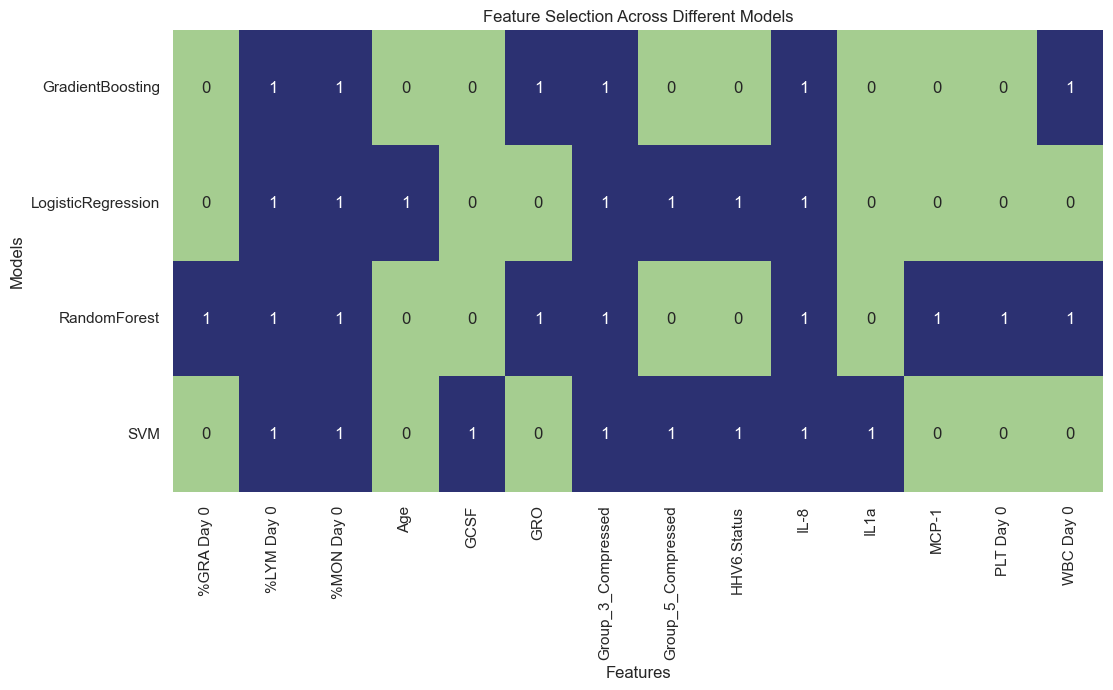

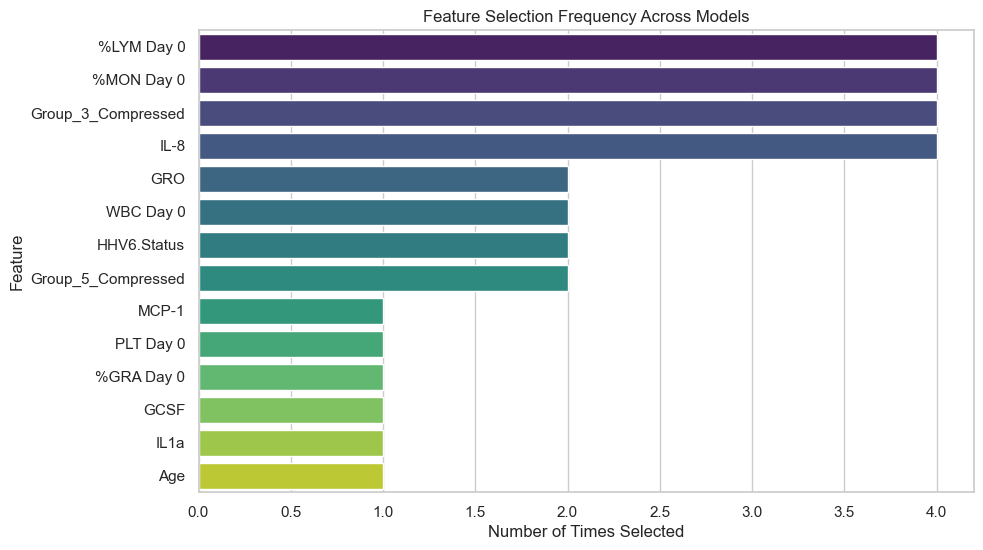

Common Features (selected by multiple models):
- %LYM Day 0
- %MON Day 0
- Group_3_Compressed
- IL-8
- GRO
- WBC Day 0
- HHV6.Status
- Group_5_Compressed

Unique Features (selected by only one model):
- MCP-1
- PLT Day 0
- %GRA Day 0
- GCSF
- IL1a
- Age


In [259]:
# Step 1: Convert to DataFrame
df_features = pd.DataFrame([(model, feature) for model, features in promising_features.items() for feature in features], columns=['Model', 'Feature'])
df_features.to_csv('../data_created/compressed_features/cv_rfe_total_results.csv', index=False)

# Step 2: Create pivot table
pivot_df = df_features.pivot_table(index='Model', columns='Feature', aggfunc=len, fill_value=0)

# Step 3: Count feature frequencies
all_features = [feature for features in promising_features.values() for feature in features]
feature_counts = Counter(all_features)
sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)

# Step 4: Plot heatmap
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_df, annot=True, cmap="crest", cbar=False)
plt.title("Feature Selection Across Different Models")
plt.xlabel("Features")
plt.ylabel("Models")
plt.show()

# Step 5a: Bar plot of feature frequencies
df_counts = pd.DataFrame(sorted_features, columns=['Feature', 'Count'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Feature', hue='Feature', data=df_counts, palette='viridis')
plt.title('Feature Selection Frequency Across Models')
plt.xlabel('Number of Times Selected')
plt.ylabel('Feature')
plt.show()

# Step 5b: Summary table of common and unique features
common_features = df_counts[df_counts['Count'] > 1]['Feature'].tolist()
unique_features = df_counts[df_counts['Count'] == 1]['Feature'].tolist()

print("Common Features (selected by multiple models):")
for feature in common_features:
    print(f"- {feature}")

print("\nUnique Features (selected by only one model):")
for feature in unique_features:
    print(f"- {feature}")

Detailed Feature Descriptions
1. %LYM Day 0 (% Lymphocytes at Day 0)
- Immune Function: Lymphocytes are crucial for the immune response, including B cells, T cells, and natural killer (NK) cells.
- Clinical Indicators: Abnormal levels can indicate infections, immune deficiencies, or chronic inflammatory conditions.
- Relevance: High or low %LYM can influence disease progression and response to treatments.

2. %MON Day 0 (% Monocytes at Day 0)
- Inflammatory Response: Monocytes differentiate into macrophages and dendritic cells, playing a role in inflammation and antigen presentation.
- Disease Association: Elevated monocyte levels can be associated with chronic inflammatory diseases, infections, and certain cancers.
- Relevance: %MON provides insights into the body’s ongoing inflammatory processes.

3. Group_3_Compressed
Original Features: ['Gender', 'RBC Day 0', 'HGB Day 0', 'HCT Day 0']
- Gender: Biological sex can influence various physiological parameters and disease susceptibilities.
- RBC, HGB, HCT: These are indicators of anemia and overall blood health, reflecting the oxygen-carrying capacity of the blood.
- Compressed Representation: Combining these features captures a holistic view of blood health and demographic factors, which may jointly influence the outcome of interest.

4. IL-8 (Interleukin-8)
- Inflammation Marker: IL-8 is a potent mediator of inflammation and is elevated in various inflammatory conditions.
- Clinical Relevance: High levels can indicate acute inflammatory responses, autoimmune diseases, and certain cancers.
- Relevance: IL-8 levels can help assess the severity of inflammation and the body’s immune response.

5. GRO (Growth-regulated Oncogene)
- Immune Response: GRO chemokines play roles in cell migration, angiogenesis, and tissue repair.
- Disease Association: Elevated GRO levels are linked to inflammatory diseases, infections, and cancer progression.
- Relevance: GRO provides information on the inflammatory state and immune cell recruitment dynamics.

6. WBC Day 0 (White Blood Cell Count on Day 0)
- Immune Health Indicator: WBC count is a fundamental measure of immune system function.
- Clinical Indicators: Abnormal WBC counts can signal infections, immune disorders, bone marrow issues, or other medical conditions.
- Relevance: WBC count helps in assessing the overall immune status and detecting potential health issues.

7. HHV6.Status (Human Herpesvirus 6 Status)
- Infection Marker: HHV-6 is associated with conditions like roseola in children and has implications in immunocompromised individuals.
- Clinical Relevance: Reactivation of HHV-6 can lead to complications in transplant patients and those with weakened immune systems.
- Relevance: HHV6.Status provides information on viral infection status, which can influence immune response and disease progression.

8. Group_5_Compressed
Original Features: ['Fractalkine', 'IL-15', 'IL-1b']
- Fractalkine: A chemokine involved in leukocyte adhesion and migration.
- IL-15: A cytokine important for the activation and proliferation of T cells and NK cells.
- IL-1b: A pro-inflammatory cytokine that plays a central role in the inflammatory response.
- Compressed Representation: Aggregating these cytokines captures a comprehensive picture of the inflammatory and immune activation status.

In [260]:
# Cytokines that don't deviate from the limit of detection
cytokines_to_remove = [
    "GCSF",
    "GM-CSF",
    "Fractalkine",
    "IFNa2",
    "IL-10",
    "MCP3",
    "IL12-p40",
    "IL12-p70",
    "IL-13",
    "IL-15",
    "IL1a",
    "IL-9",
    "IL-1b",
    "IL-2",
    # "IL-3", i don't have these
    # "IL-4", i don't have these
    "IL-5",
    "IL-6",
    "IL-7",
    "TNFb"
]


# Prepare your data
X = merged_data.drop(columns=['Vaccinee', 'response_label'])
X = X.drop(columns=cytokines_to_remove)
y = merged_data['response_label']
print(X.columns)

promising_features = {}


Index(['CMV.Status', 'EBV.Status', 'HSV1_2.Status', 'HHV6.Status', 'EGF',
       'FGF-2', 'Eotaxin', 'TGF-a', 'Flt3 Ligand', 'IFNg', 'GRO', 'MDC',
       'sCD40L', 'IL17A', 'IL1Ra', 'IL-8', 'IP-10', 'MCP-1', 'MIP1a', 'MIP1b',
       'TNFa', 'VEGF', 'WBC Day 0', 'RBC Day 0', 'HGB Day 0', 'HCT Day 0',
       'PLT Day 0', '%LYM Day 0', '%MON Day 0', '%GRA Day 0', 'Gender', 'Age'],
      dtype='object')


Stratified CV Progress: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]

Stable Features: ['GRO', 'MCP-1', 'RBC Day 0', 'HGB Day 0', 'HCT Day 0', '%LYM Day 0', '%MON Day 0', '%GRA Day 0', 'IL17A', 'PLT Day 0']


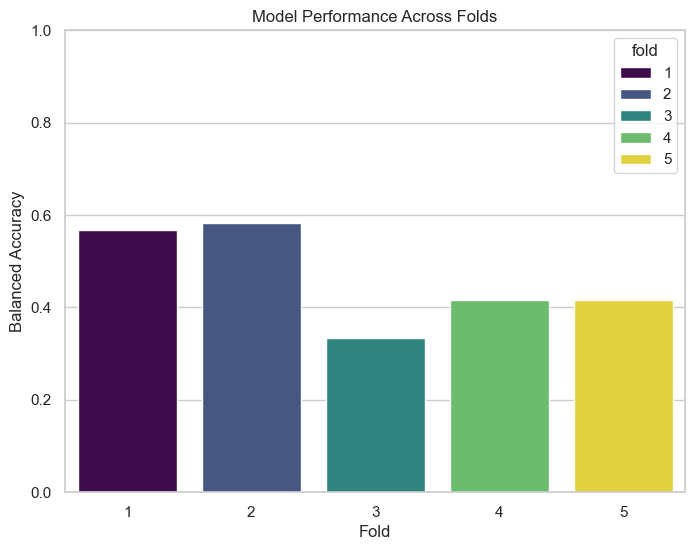

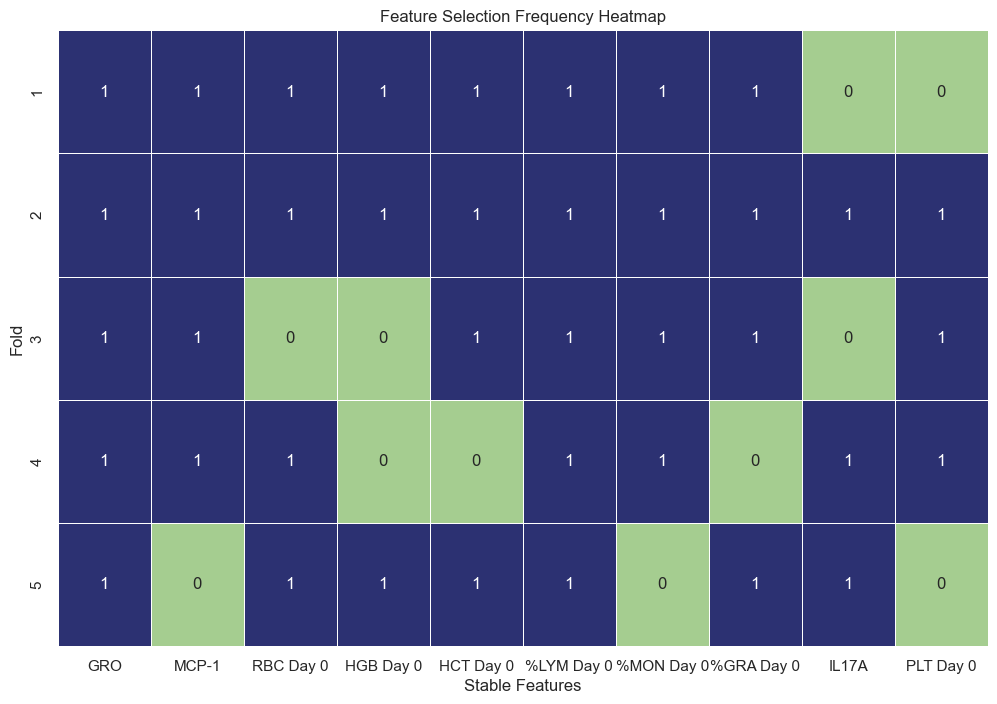

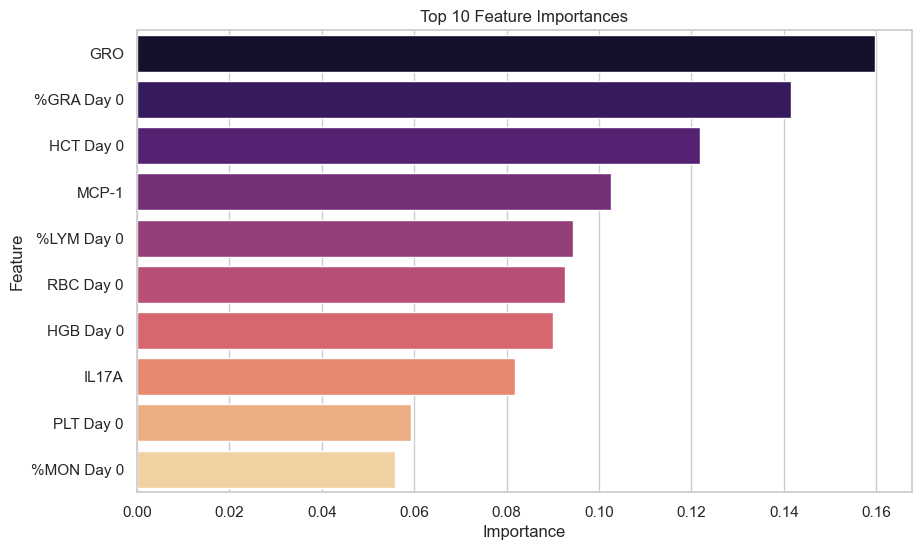

In [261]:
# Define the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Run RFE Analysis
result = run_rfe_analysis(
    X=X,
    y=y,
    model=rf_model,
    max_features=10,
    cv_folds=5,
    threshold=3,
    output_csv_path='../data_created/removed_features/cv_rfe_RF_results.csv',
    top_n_importances=10,
    plot_importances_func=plot_feature_importances
)
promising_features["RandomForest"] = result

Stratified CV Progress: 100%|██████████| 5/5 [00:00<00:00, 33.24it/s]

Stable Features: ['MCP-1', 'VEGF', '%MON Day 0', 'Gender', 'Age', 'HGB Day 0']


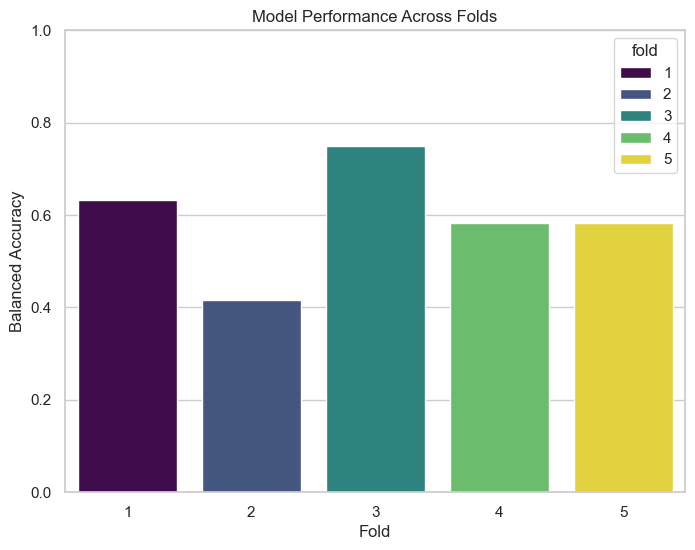

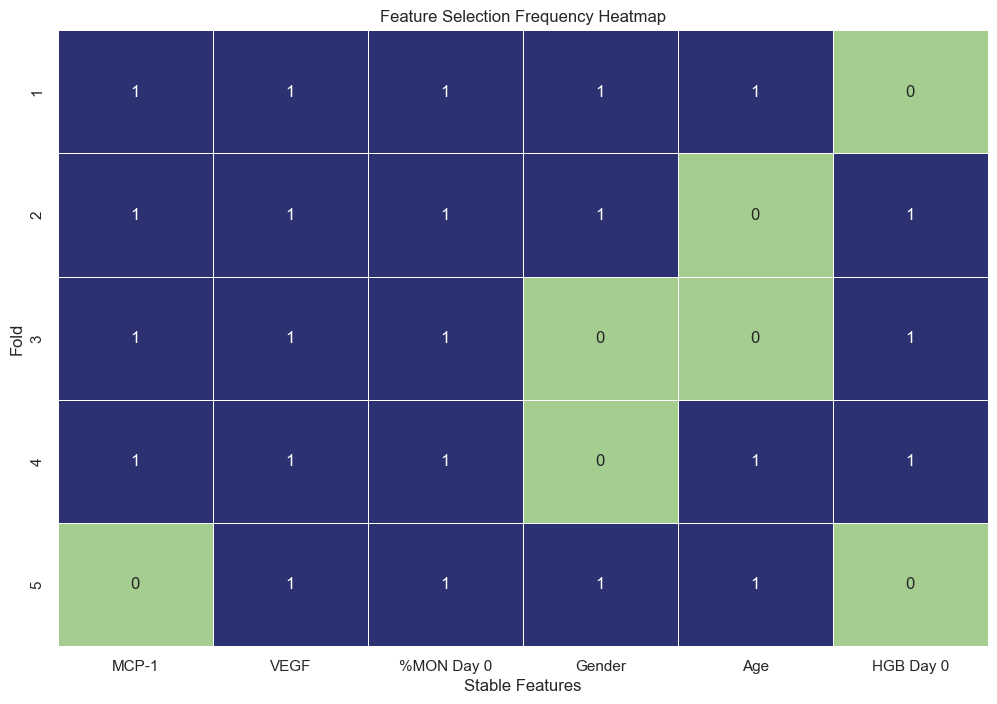

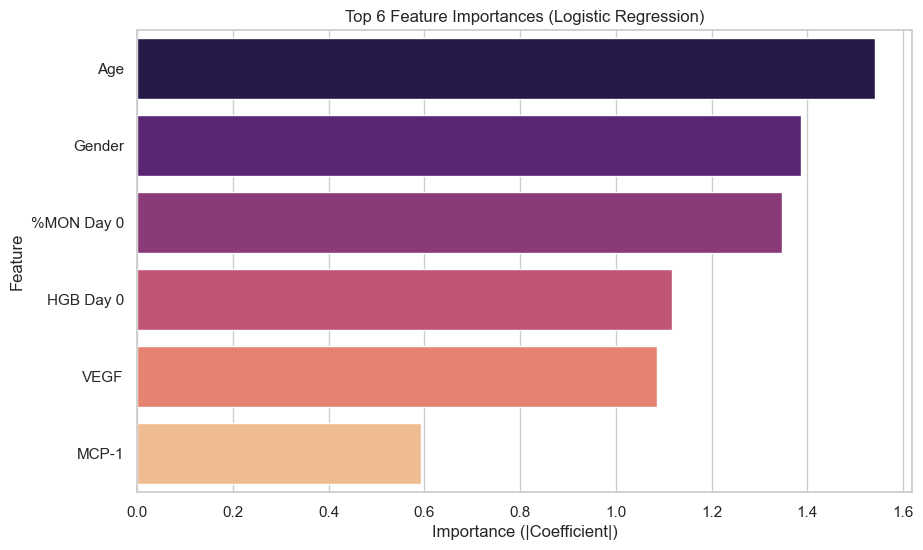

In [262]:
# Initialize the SVM Model
svm_model = SVC(kernel='linear',  probability=True, random_state=42)

result = run_rfe_analysis(
    X=X,
    y=y,
    model=svm_model,
    max_features=10,
    cv_folds=5,
    threshold=3,
    output_csv_path='../data_created/removed_features/cv_rfe_SVM_results.csv',
    top_n_importances=10,
    plot_importances_func=plot_feature_importances_linear
)
promising_features["SVM"] = result

Stratified CV Progress: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]

Stable Features: ['EGF', 'GRO', 'WBC Day 0', '%LYM Day 0', '%MON Day 0', 'VEGF']


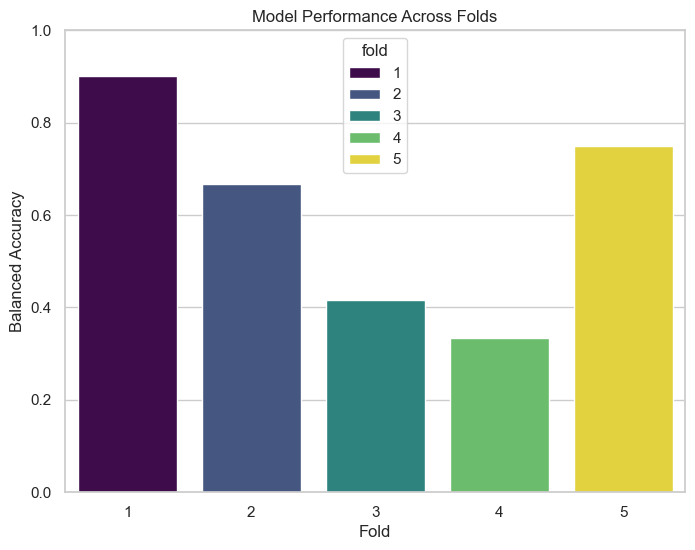

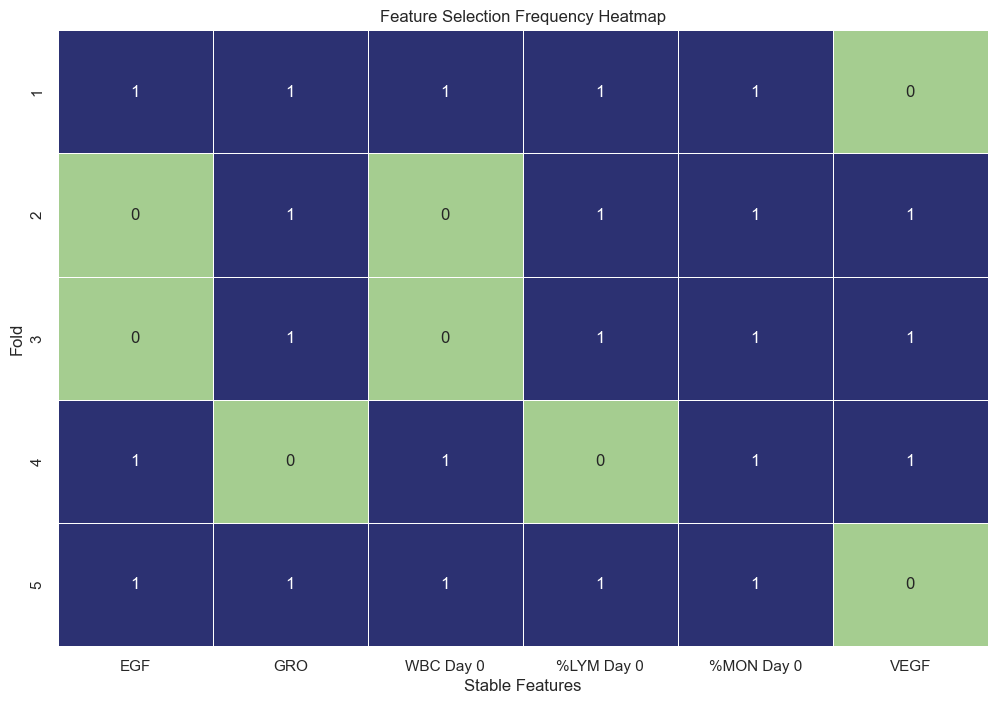

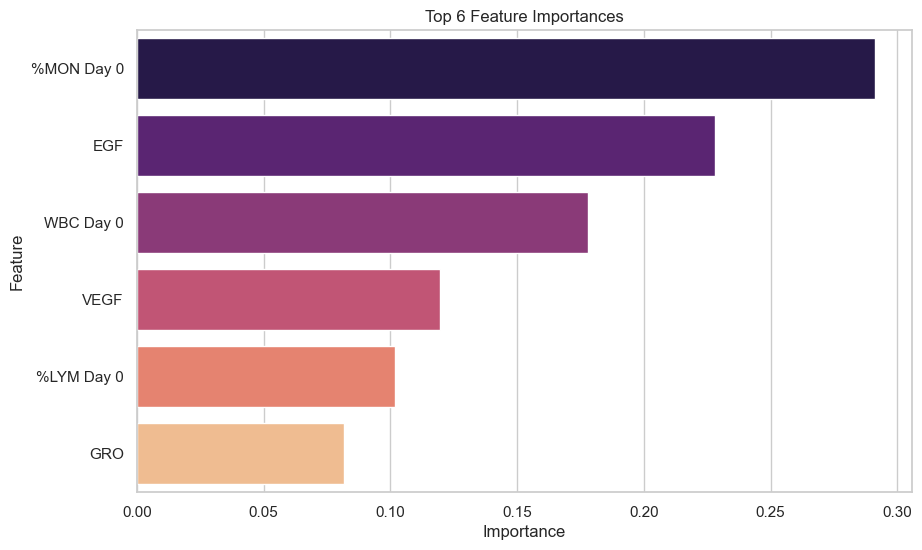

In [263]:
# Initialize the Gradient Boosting Model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

result = run_rfe_analysis(
    X=X,
    y=y,
    model=gb_model,
    max_features=10,
    cv_folds=5,
    threshold=3,
    output_csv_path='../data_created/removed_features/cv_rfe_GB_results.csv',
    top_n_importances=10,
    plot_importances_func=plot_feature_importances
)
promising_features["GradientBoosting"] = result

Stratified CV Progress: 100%|██████████| 5/5 [00:00<00:00, 53.22it/s]

Stable Features: ['CMV.Status', 'HHV6.Status', 'IL-8', 'IP-10', 'MCP-1', 'VEGF', '%LYM Day 0', '%MON Day 0', 'Gender', 'Age', 'MIP1b']


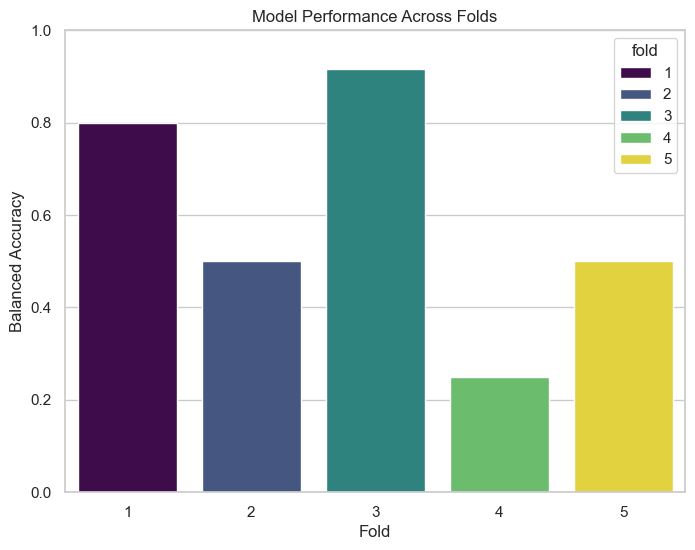

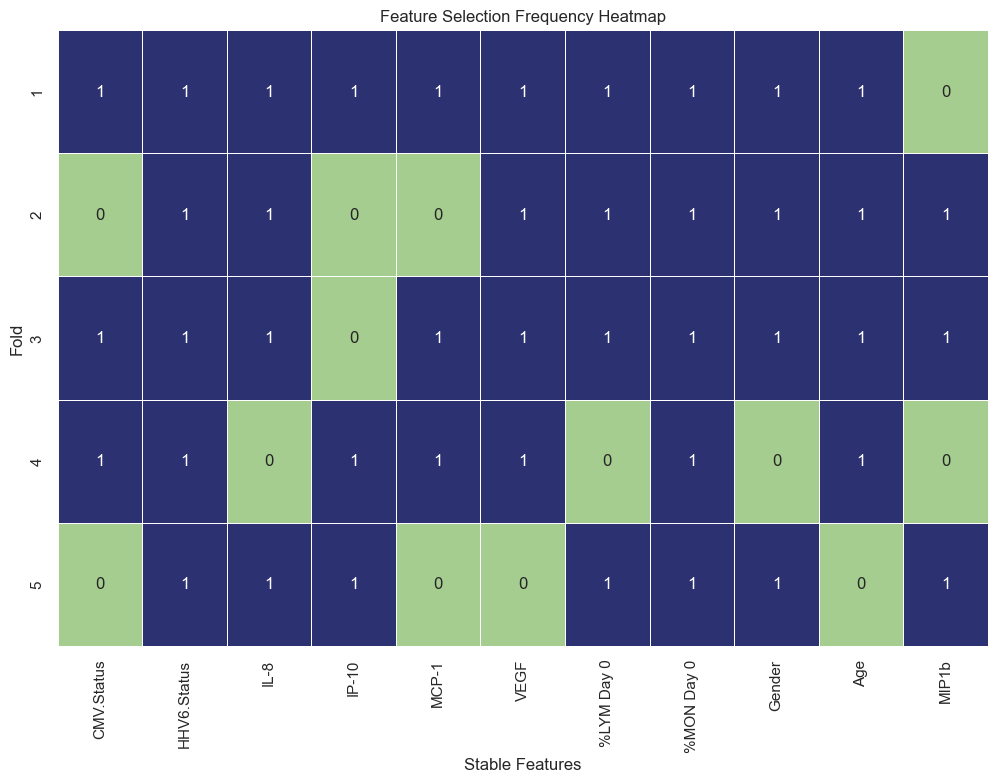

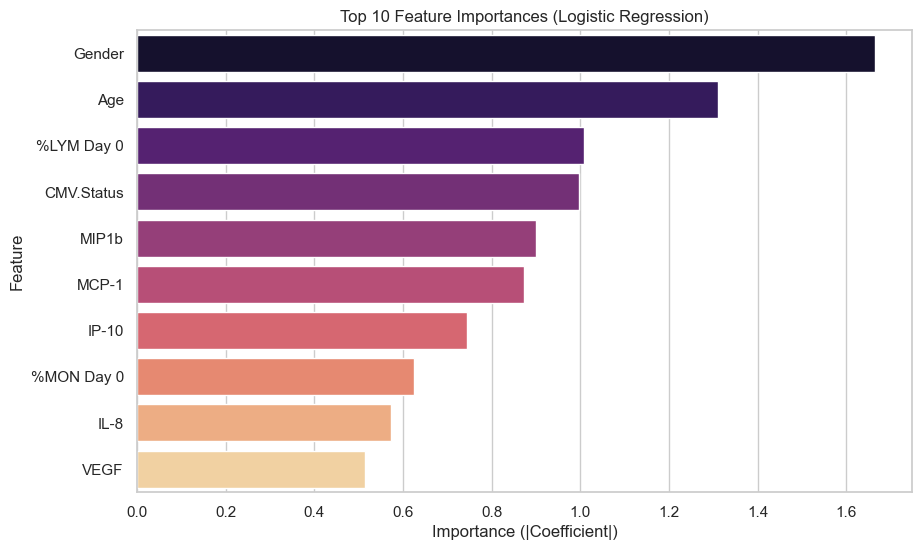

In [264]:
logreg_model = LogisticRegression(penalty='l1', solver='liblinear',  random_state=42)

result = run_rfe_analysis(
    X=X,
    y=y,
    model=logreg_model,
    max_features=10,
    cv_folds=5,
    threshold=3,
    output_csv_path='../data_created/removed_features/cv_rfe_LogReg_results.csv',
    top_n_importances=10, 
    plot_importances_func=plot_feature_importances_linear
)
promising_features["LogisticRegression"] = result

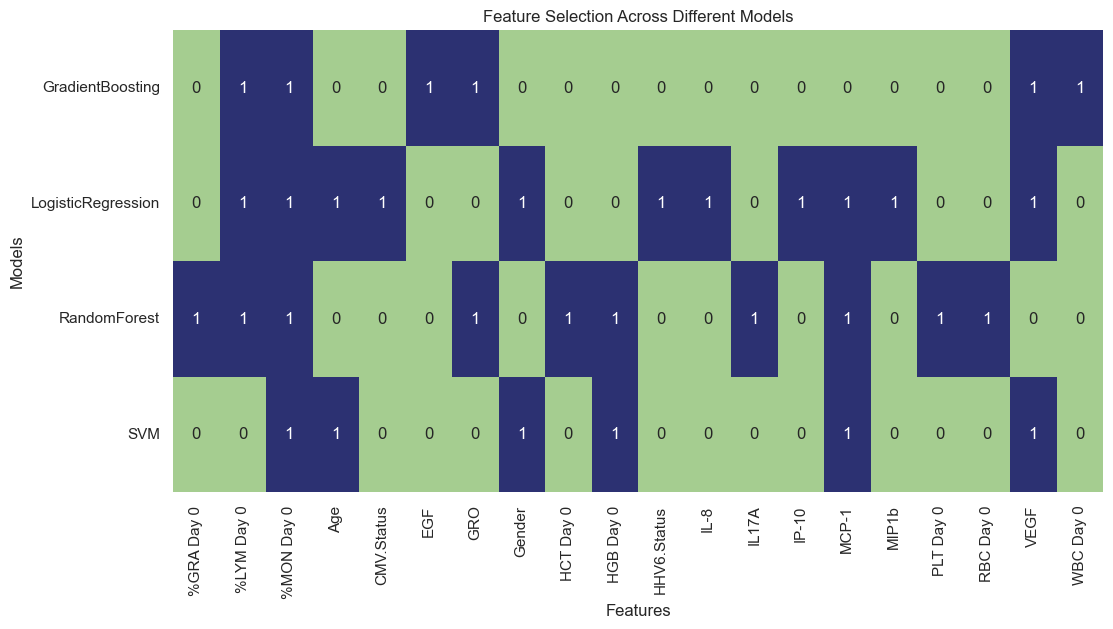

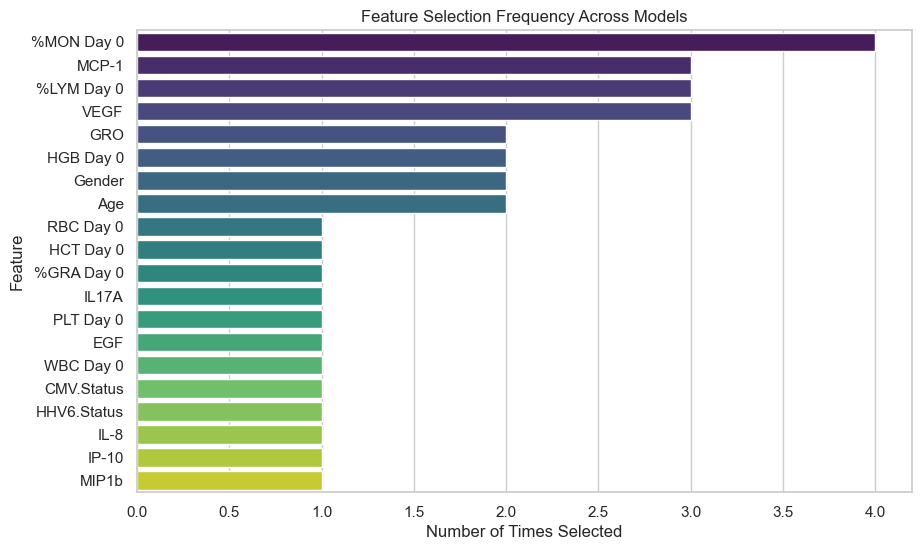

Common Features (selected by multiple models):
- %MON Day 0
- MCP-1
- %LYM Day 0
- VEGF
- GRO
- HGB Day 0
- Gender
- Age

Unique Features (selected by only one model):
- RBC Day 0
- HCT Day 0
- %GRA Day 0
- IL17A
- PLT Day 0
- EGF
- WBC Day 0
- CMV.Status
- HHV6.Status
- IL-8
- IP-10
- MIP1b


In [265]:
# Step 1: Convert to DataFrame
df_features = pd.DataFrame([(model, feature) for model, features in promising_features.items() for feature in features], columns=['Model', 'Feature'])
df_features.to_csv('../data_created/removed_features/cv_rfe_total_results.csv', index=False)

# Step 2: Create pivot table
pivot_df = df_features.pivot_table(index='Model', columns='Feature', aggfunc=len, fill_value=0)

# Step 3: Count feature frequencies
all_features = [feature for features in promising_features.values() for feature in features]
feature_counts = Counter(all_features)
sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)

# Step 4: Plot heatmap
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_df, annot=True, cmap="crest", cbar=False)
plt.title("Feature Selection Across Different Models")
plt.xlabel("Features")
plt.ylabel("Models")
plt.show()

# Step 5a: Bar plot of feature frequencies
df_counts = pd.DataFrame(sorted_features, columns=['Feature', 'Count'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Feature', hue='Feature', data=df_counts, palette='viridis')
plt.title('Feature Selection Frequency Across Models')
plt.xlabel('Number of Times Selected')
plt.ylabel('Feature')
plt.show()

# Step 5b: Summary table of common and unique features
common_features = df_counts[df_counts['Count'] > 1]['Feature'].tolist()
unique_features = df_counts[df_counts['Count'] == 1]['Feature'].tolist()

print("Common Features (selected by multiple models):")
for feature in common_features:
    print(f"- {feature}")

print("\nUnique Features (selected by only one model):")
for feature in unique_features:
    print(f"- {feature}")